In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

In [3]:
bGENPATH = Path("/home/mkk/Downloads/behavior_from_behavior_100000/")
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR6/")
def load_genbehavior(path, temp):
    filepath = path.joinpath(f"temperature={temp}.csv")
    x = np.loadtxt(filepath, skiprows=1, delimiter=",")
    bangle, dt, dist, state = x.T
    return bangle, dt, dist, (state-1).astype(np.int_)    
    
def load_behavior(path, temp):
    file = h5py.File(path, "r")
    grp = file[f"behaviour/{temp}"]
    bangle = format_sequences(grp["dtheta"][()])
    dist = format_sequences(grp["displacements"][()])
    dt = format_sequences(grp["interboutintervals"][()])
    file.close()
    return bangle, dt, dist

def load_genneuro(path, fish, temp):
    paths = sorted(nGENPATH.glob(f"temperature={temp}-fish={fish}-rep=*.csv"))
    #print(paths)
    BANGLES, DISTS, DTS, STATES = [], [], [], []
    for path in paths:
        x = np.loadtxt(path, skiprows=1, delimiter=",")
        bangle, dt, dist, state = x.T
        BANGLES.append(bangle)
        DISTS.append(dist)
        DTS.append(dt)
        STATES.append((state-1).astype(np.int_))
    #return BANGLES, DISTS, DTS, STATES
    return BANGLES, DTS, DISTS, STATES

In [4]:
def reconstruct_trajs(dthets, dists):
    """Reconstruct (x,y) trajectory from a sequencere-orientation angles.
    
    Parameters :
    ------------
    dthets : 1d array
        sequence of re-orientation angles
    dists : 1d array
        sequence of bout distance

    Return :
    --------
    x : 1d array
        reconstructed x positions
    y : 1d array
        reconstructed y positions
    """
    angles = np.cumsum(-np.deg2rad(dthets))
    dxy =  dists[:,np.newaxis] * np.c_[np.cos(angles), np.sin(angles)]
    x,y = tuple(np.cumsum(dxy, axis=0).T)
    return x, y

# Figures

## Distributions

In [5]:
i = 3
artr = ALL_ARTRs[i]
print(artr)

temp = artr[1]
ANGLEs, DTs, DISTs = load_behavior(bDATAPATH, temp)
bangle, bdt, bdist, bstate = load_genbehavior(bGENPATH, temp)
nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)

[11 22]


In [6]:
def hist(X, bins=None):
    h_x, b_x = np.histogram(X, bins=bins, density=True)
    #print(h_x.sum())
    h_x[h_x==0] = np.nan
    return h_x, (b_x[1:] + b_x[:-1])/2

nbins = 75

h_ANGLES, b_ANGLES = hist(np.concatenate(ANGLEs), bins=np.linspace(-100, +100, 10*nbins))
h_bangles, b_bangles = hist(bangle, bins=np.linspace(-100, +100, nbins))
h_nangles, b_nangles = hist(np.concatenate(nangle), bins=np.linspace(-100, +100, nbins))

h_DT, b_DT = hist(np.concatenate(DTs), bins=np.linspace(0, 20, 10*nbins))
h_bdt, b_bdt = hist(bdt, bins=np.linspace(0, 20, nbins))
h_ndt, b_ndt = hist(np.concatenate(ndt), bins=np.linspace(0, 20, nbins))

h_DIST, b_DIST = hist(np.concatenate(DISTs), bins=np.linspace(0, 10, 10*nbins))
h_bdist, b_bdist = hist(bdist, bins=np.linspace(0, 10, nbins))
h_ndist, b_ndist = hist(np.concatenate(ndist), bins=np.linspace(0, 10, nbins))

(0.0002, 6.0)

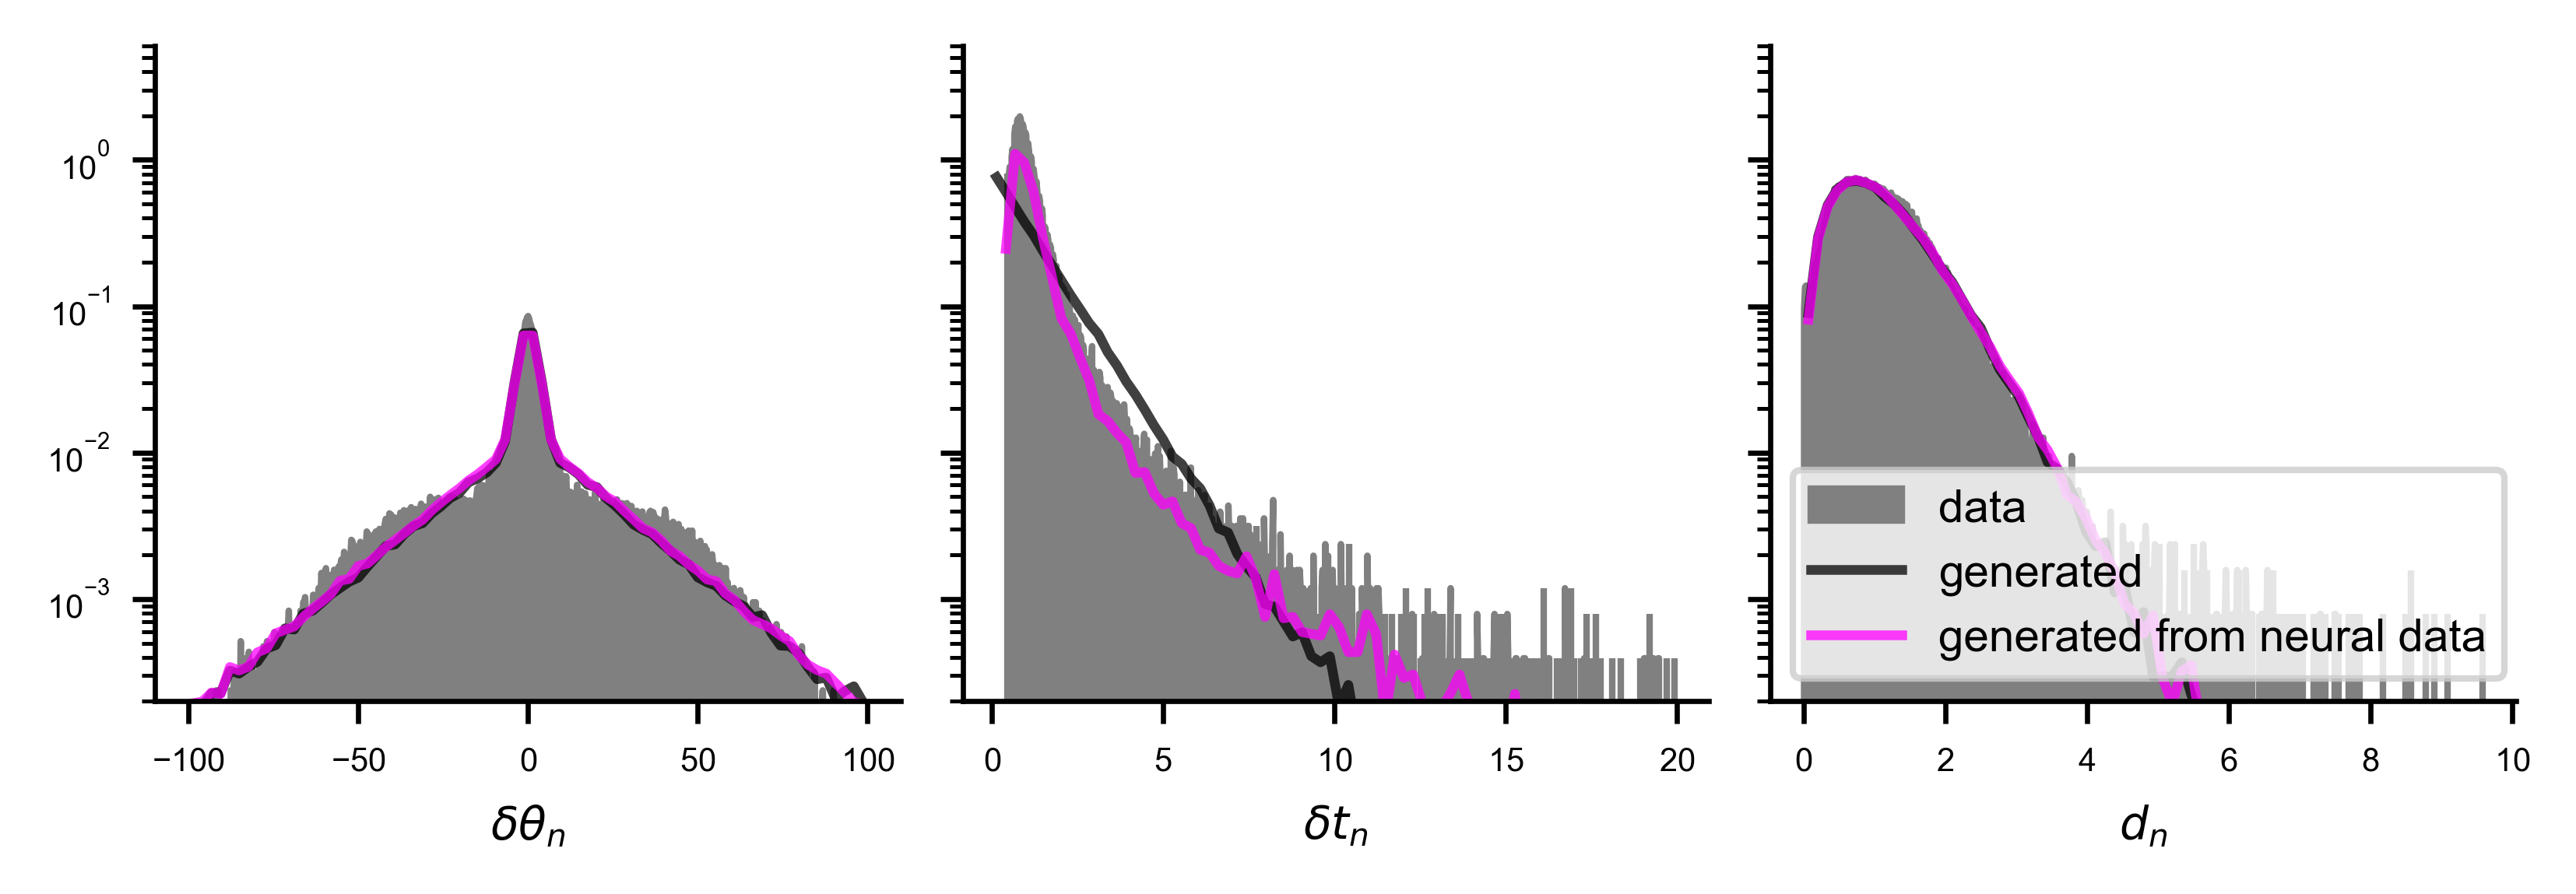

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(3*1.8,1.8), sharey=True)
for ax in axs:
    ax.set_yscale("log")
#ax.set_ylim(1.e-4, 10.e0)

data_color = "grey"
bgen_color = "k"
ngen_color = "magenta"
gen_alpha = 0.75
border = 1
norder = 2
ORDER = 0

ax = axs[0]
ax.fill_between(b_ANGLES, h_ANGLES, zorder=ORDER, color=data_color)
ax.plot(b_bangles, h_bangles, color=bgen_color, alpha=gen_alpha, zorder=border)
ax.plot(b_nangles, h_nangles, color=ngen_color, alpha=gen_alpha, zorder=norder)
ax.set_xlabel(r"$\delta\theta_n$")
#ax.set_ylabel("Density")

ax = axs[1]
ax.fill_between(b_DT, h_DT, zorder=ORDER, color=data_color)
ax.plot(b_bdt, h_bdt, color=bgen_color, alpha=gen_alpha, zorder=border)
ax.plot(b_ndt, h_ndt, color=ngen_color, alpha=gen_alpha, zorder=norder)
ax.set_xlabel(r"$\delta t_n$")

ax = axs[2]
ax.fill_between(b_DIST, h_DIST, zorder=ORDER, color=data_color, label="data")
ax.plot(b_bdist, h_bdist, color=bgen_color, alpha=gen_alpha, label="generated", zorder=border)
ax.plot(b_ndist, h_ndist, color=ngen_color, alpha=gen_alpha, label="generated from neural data", zorder=norder)
ax.set_xlabel(r"$d_n$")

ax.legend()
ax.set_ylim(2.e-4, 6.e0)


#fig.savefig("panels/Fig6/BfromB_and_BfromN_hists.svg")

## Behavior Generated Trajectory

In [78]:
x, y = reconstruct_trajs(bangle, bdist)

truncated at 5.996111422581752 min


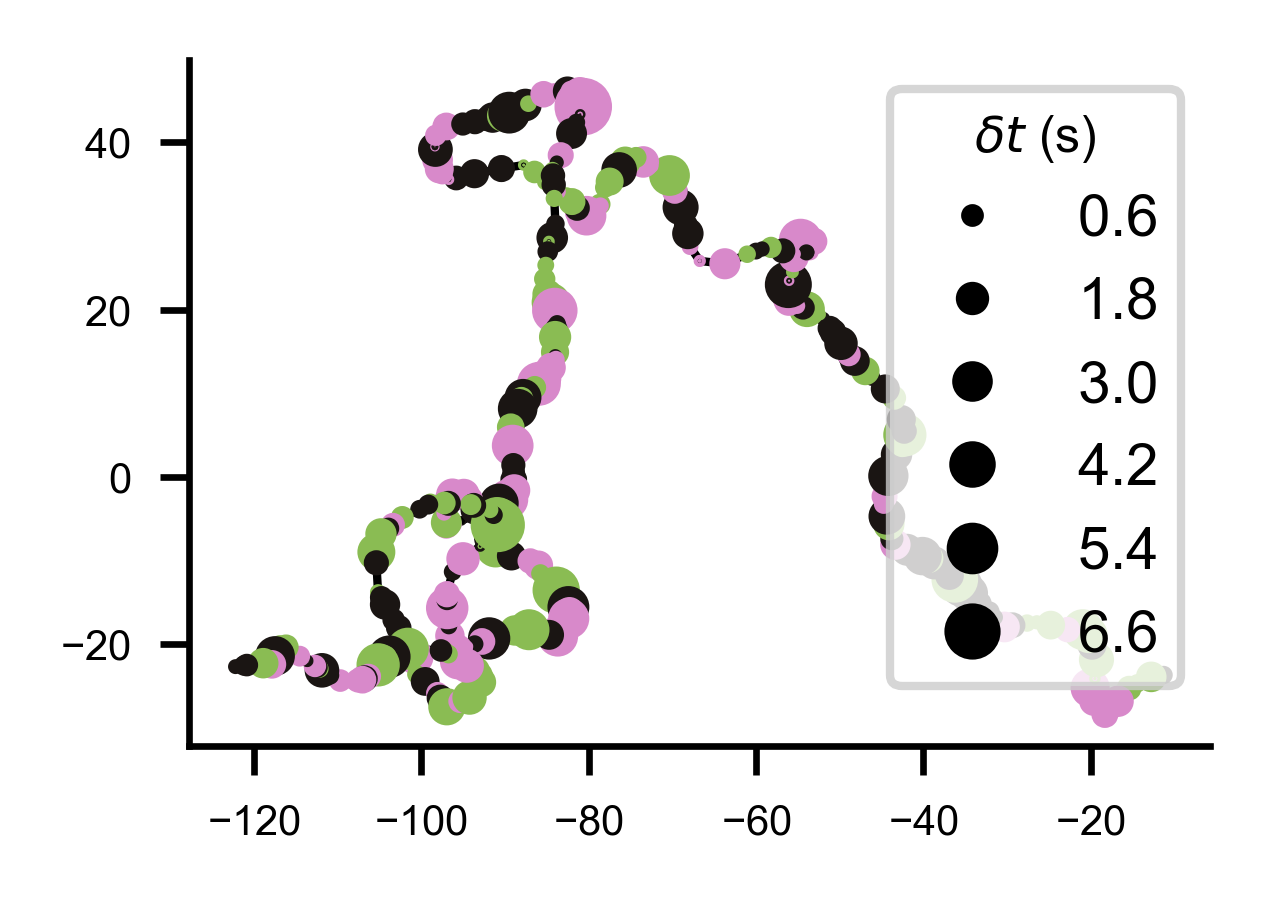

In [90]:
n1,n2 = 500,850
fig, ax = plt.subplots()
ax.plot(x[n1:n2],y[n1:n2], zorder=0, linewidth=1)
scat = ax.scatter(x[n1:n2],y[n1:n2], s=bdt[n1:n2]*5, c=FLR_colors[np.insert(bstate[n1+1:n2], -1,0)], zorder=1)
print(f"truncated at {np.sum(bdt[n1:n2])/60} min")
ax.set_aspect(1)
handles, labels = scat.legend_elements(prop="sizes")
hands, labs = [], []
for h,l in zip(handles[::2], labels[::2]):
    size = int(l.split("{")[-1].split("}")[0])/5
    lab = r"$\mathdefault{"+str(size)+"}$"
    hands.append(h)
    labs.append(lab)
legnd = plt.legend(hands, labs, title=r"$\delta t$ (s)")

fig.savefig("panels/Fig6/BfromB_traj.svg")

## Neuro Generated Trajectories

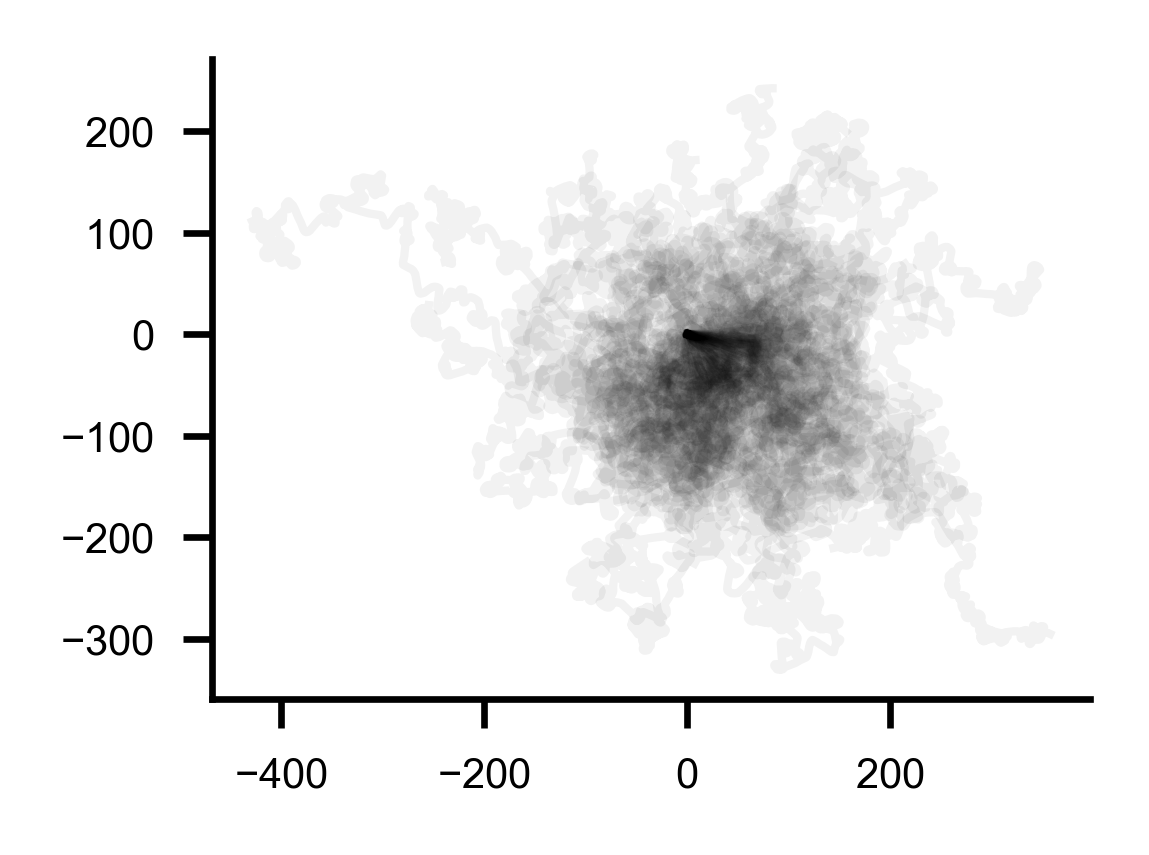

In [8]:
fig, ax = plt.subplots(figsize=(1.8,1.8))
ax.set_aspect(1)
for j in range(len(nangle)):
    x, y = reconstruct_trajs(nangle[j], ndist[j])
    dtt = ndt[j]
    statee = nstate[j]
    ax.plot(x,y, color="k", alpha=0.05, zorder=0, linewidth=1)
    #ax.scatter(x,y, s=dtt*5, c=FLR_colors[np.insert(statee[1:], -1,0)], zorder=1, alpha=0.1)

#fig.savefig("panels/Fig6/BfromN_trajs.svg")

### example trajectory

truncated at 5.305767666935231 min


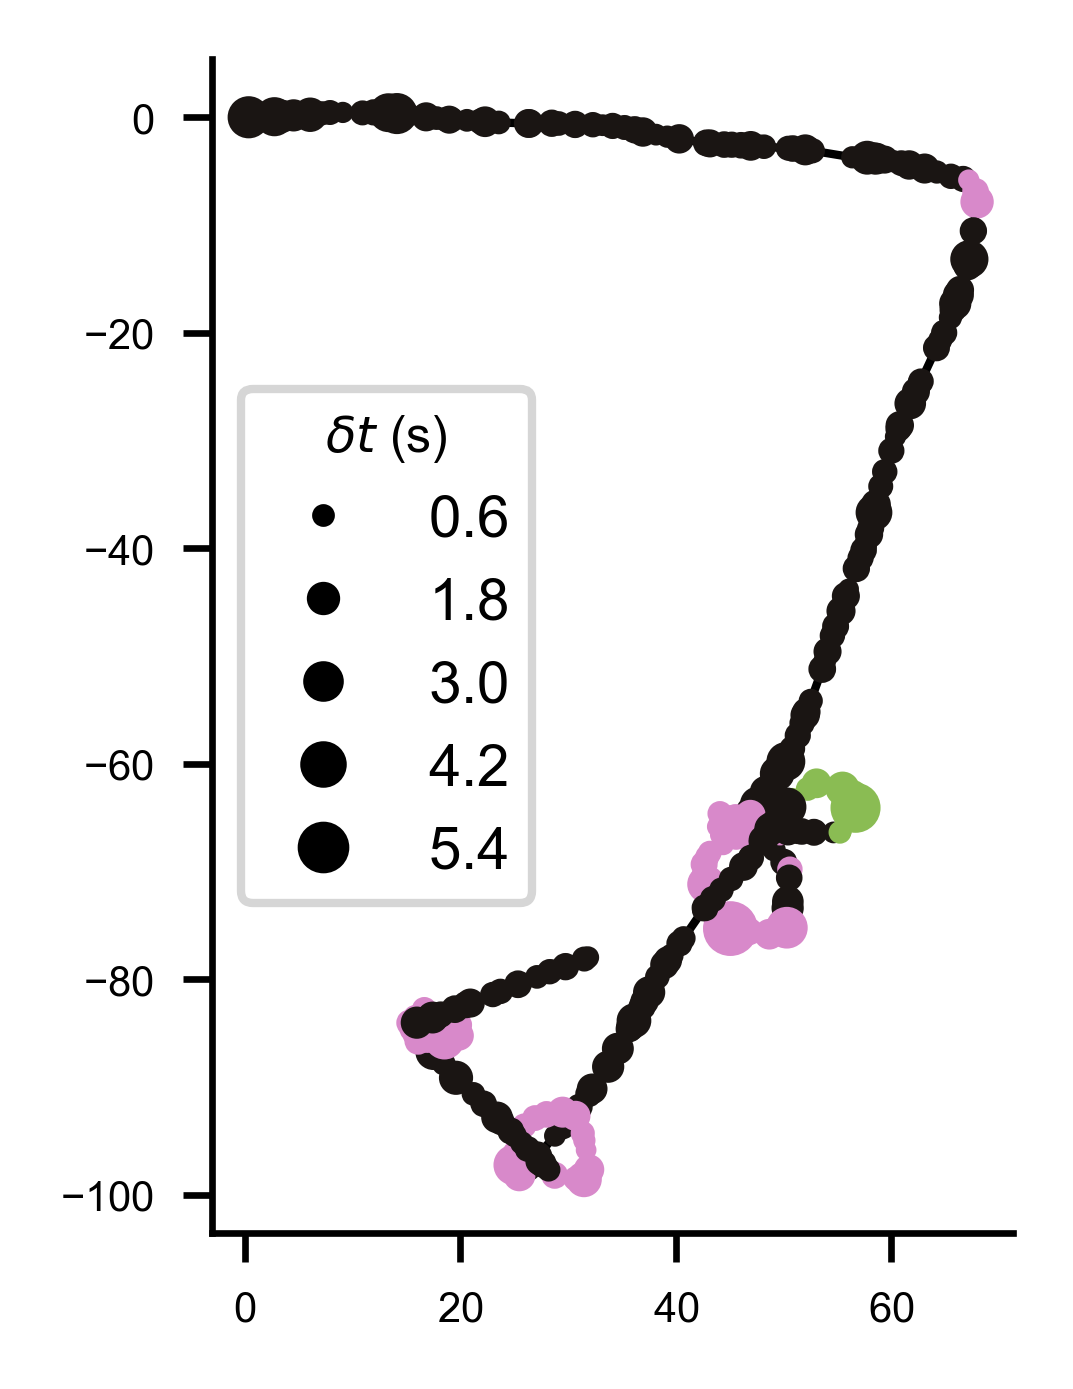

In [9]:
j = 3
end = 291
x, y = reconstruct_trajs(nangle[j], ndist[j])
dtt = ndt[j] ; print(f"truncated at {np.sum(dtt[:end])/60} min")
statee = nstate[j]
fig, ax = plt.subplots(figsize=(2.2,2.2))
ax.plot(x[:end],y[:end], zorder=0, linewidth=1)
scat = ax.scatter(x[:end],y[:end], s=dtt[:end]*5, c=FLR_colors[np.insert(statee[1:end], -1,0)], zorder=1)
ax.set_aspect(1)
handles, labels = scat.legend_elements(prop="sizes")
hands, labs = [], []
for h,l in zip(handles[::2], labels[::2]):
    size = int(l.split("{")[-1].split("}")[0])/5
    lab = r"$\mathdefault{"+str(size)+"}$"
    hands.append(h)
    labs.append(lab)
legnd = plt.legend(hands, labs, title=r"$\delta t$ (s)")
#fig.savefig("panels/Fig6/BfromN_traj.svg")

## Translated Neuro Activity

In [10]:
from matplotlib.gridspec import GridSpec
from scipy.cluster import hierarchy

In [11]:
mL, mR, L,R,dt = load_ARTR(nDATAPATH, *artr)

In [12]:
seq = load_ARTR_viterbi(nOUTPATH, *artr)

In [13]:
neuro_duration = dt*L.shape[0]#t[-1]
neuro_duration/60

20.000040506751123

In [14]:
def find_closest(x, Y):
    return np.argmin(np.abs(x - Y))

def find_closests(X, Y):
    return np.array([find_closest(x,Y) for x in X])

In [15]:
times = np.linspace(0, neuro_duration, 6000)

In [16]:
states = np.full((len(nstate),len(times)), -1)
for i in range(len(nstate)):
    #ts = find_closests(np.cumsum(ndt[i]) * (neuro_duration / genneuro_durations[i]), times)
    ts = find_closests(np.cumsum(ndt[i]) * 1/(0.44), times)
    ts = np.insert(ts, 0, 0)
    for j in range(0, len(ts)-1):
        states[i,ts[j]:ts[j+1]] = nstate[i][j]

In [17]:
X = np.corrcoef(states)
Z = hierarchy.ward(X)
order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))

In [18]:
FLRN_colors = np.vstack([FLR_colors, np.array([1,1,1,1])])

(0.0, 100.0)

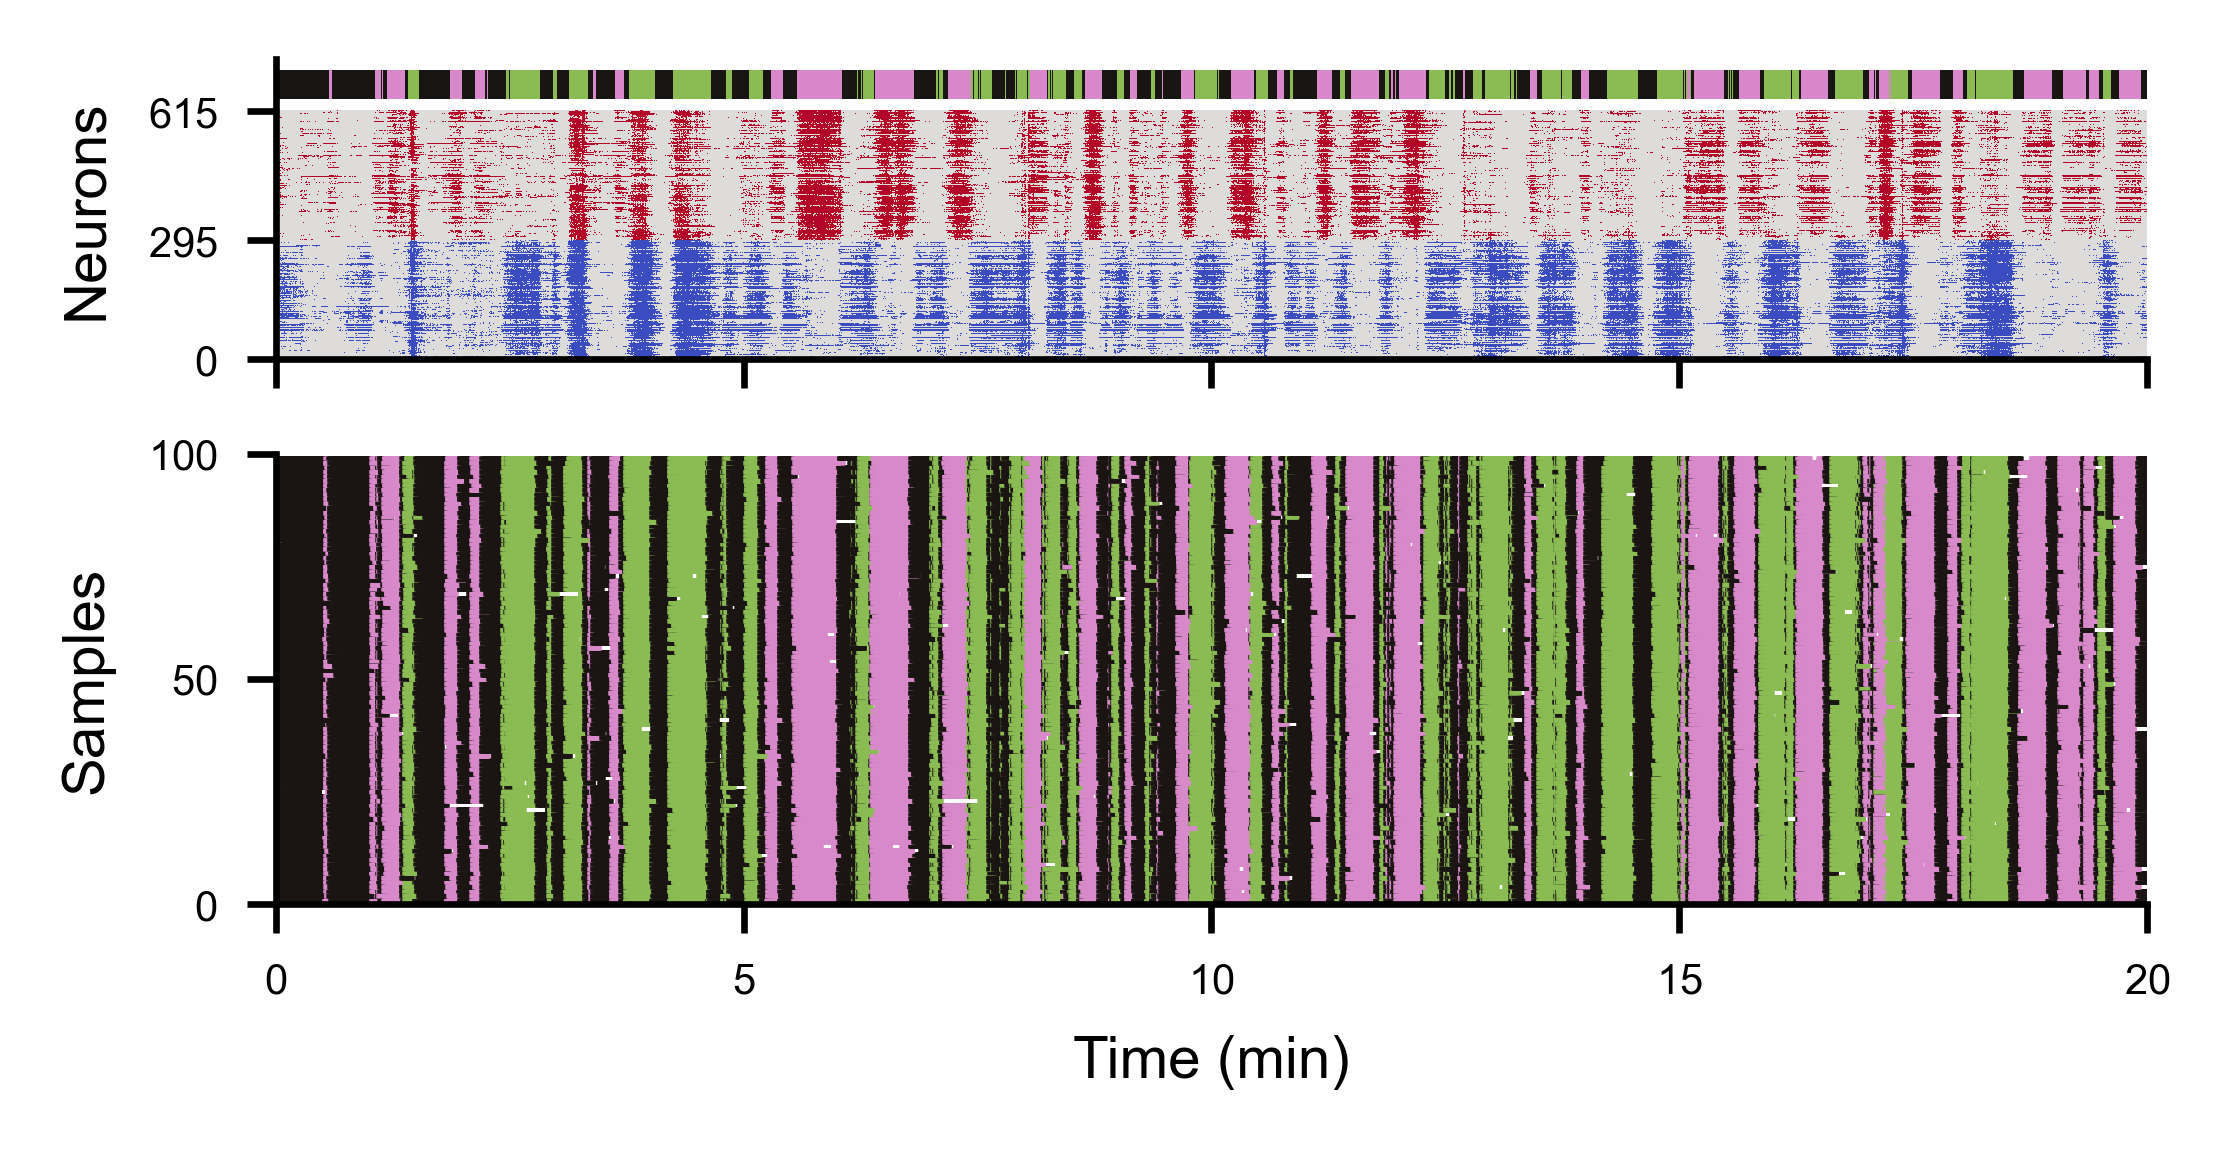

In [21]:
fig = plt.figure(figsize=(2*1.8,1.8))
gs = GridSpec(2,1,fig, height_ratios=[2/5, 3/5])

ax1 = plt.subplot(gs[0])
t = np.arange(0,len(mL)*dt, dt)
ypad = 30
yext = 100
ax1.imshow(
    np.c_[-L.astype(np.int_),R.astype(np.int_)].T, 
    cmap=ARTR_CMAP, vmin=-1, vmax=+1,
    extent=(0, t[-1]/60, 0, L.shape[1] + R.shape[1]),
    rasterized=True
)
ax1.imshow(
    FLR_colors[seq[np.newaxis,:]], 
    extent=(0,t[-1]/60, L.shape[1] + R.shape[1] + ypad,L.shape[1] + R.shape[1] + yext),
    rasterized=True
)
ax1.set_ylabel("Neurons")
ax1.set_ylim(0, L.shape[1] + R.shape[1] + ypad + yext)
ax1.set_xticklabels([])
ax1.set_xticks([0,5,10,15,20])
ax1.set_yticks([0,L.shape[1], L.shape[1] + R.shape[1]])

"""
ax2 = plt.subplot(gs[1])
ax2.imshow(FLRN_colors[states[order,:]], extent=(0, t[-1]/60, 0, len(nstate)),rasterized=True)
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Samples")
ax2.set_xlim(*ax1.get_xlim())
ax2.set_xticks([0,5,10,15,20])
ax2.set_yticks([0,50,100])
"""

ax2 = plt.subplot(gs[1])
for i in range(len(ndt)):
    #ax2.scatter(np.cumsum(ndt[i])/60/0.44,ndt[i]*0+i, marker="|", s=0.3, c=FLR_colors[nstate[i]], rasterized=True)
    ax2.scatter(np.cumsum(ndt[i])/60*0.44,ndt[i]*0+i, marker="|", s=0.3, c=FLR_colors[nstate[i]], rasterized=True)
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Samples")
ax2.set_xlim(*ax1.get_xlim())
ax2.set_xticks([0,5,10,15,20])
ax2.set_yticks([0,50,100])
ax2.set_ylim(0,len(ndt))

#fig.savefig("panels/Fig6/BfromN_samples.svg")

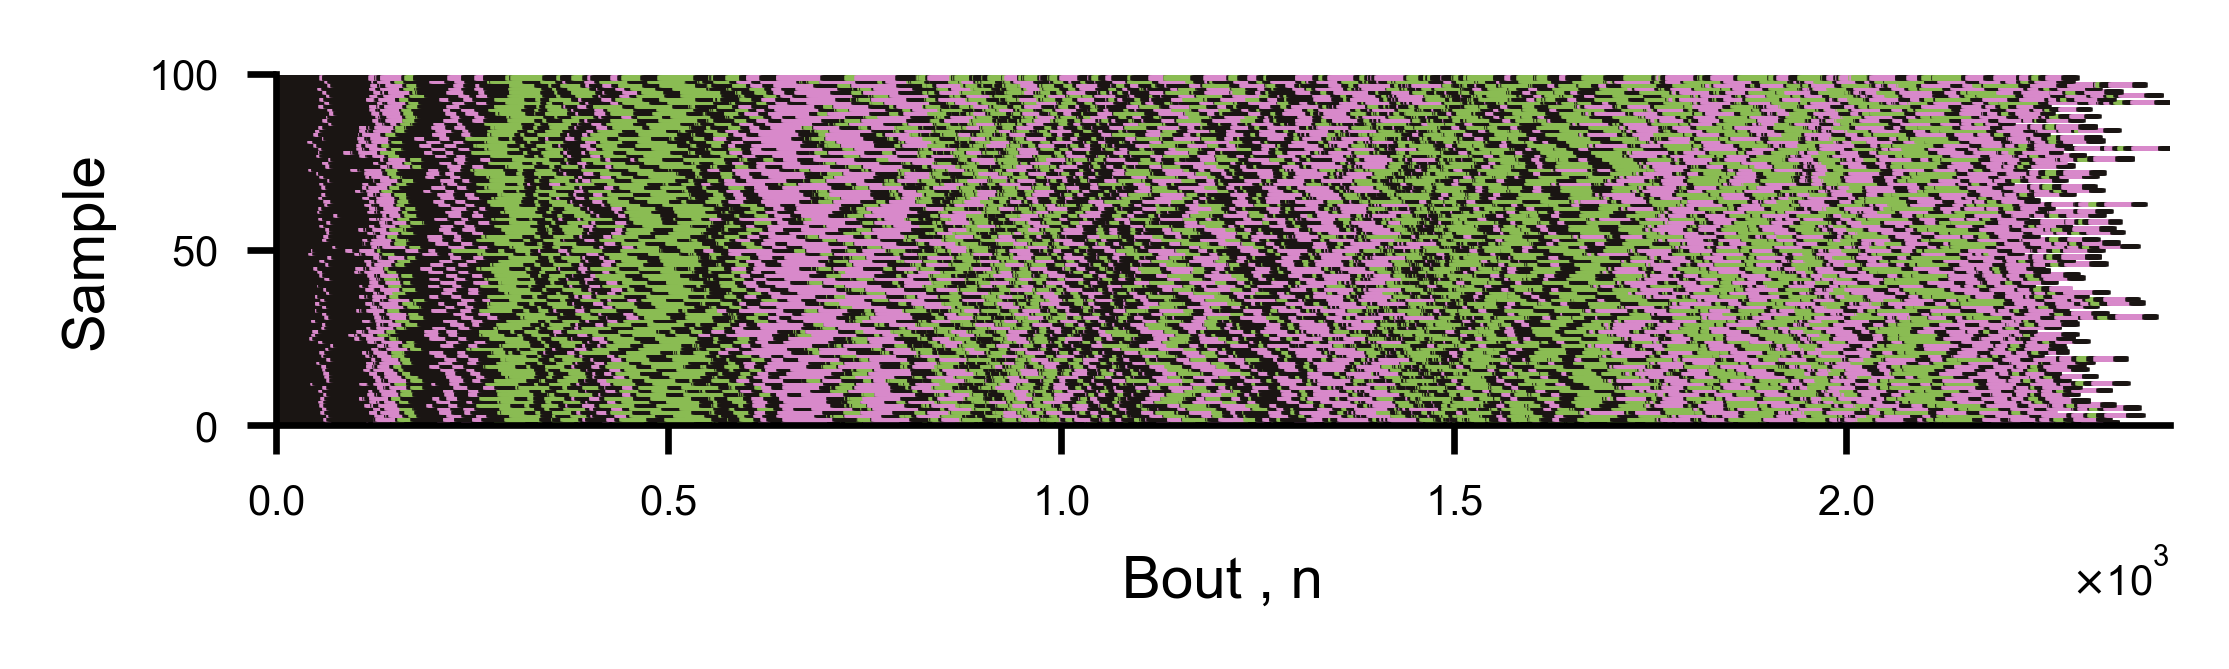

In [22]:
fig, ax = plt.subplots(figsize=(2*1.8,1))
for i in range(len(nstate)):
    ax.scatter(np.arange(len(nstate[i])),nstate[i]*0+i, marker="|", s=0.3, c=FLR_colors[nstate[i]], rasterized=True)
ax.set_xlabel("Bout , n")
ax.set_ylabel("Sample")
ax.set_xlim(0, np.max([len(a) for a in nstate]))
ax.set_ylim(0,len(nstate))
ax.set_yticks([0,50,100])

#fig.savefig("panels/Fig6/supps/BfromN_samples_perbout.svg")

## Diagram

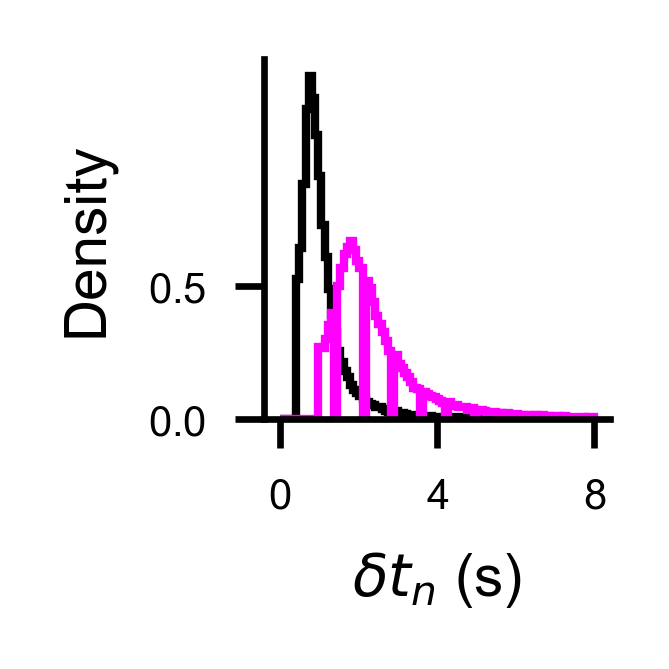

In [27]:
fig, ax = plt.subplots(figsize=(1,1))
bins = np.linspace(0, 8, 100)
ax.hist(np.concatenate(DTs), bins=bins, histtype="step", density=True, color="black");
ax.hist(np.concatenate(DTs)/0.44, bins=bins, histtype="step", density=True, color="magenta");
ax.set_xlabel(r"$\delta t_n$ (s)")
ax.set_ylabel("Density")
ax.set_xticks([0,4,8])
ax.set_yticks([0,0.5])
#fig.savefig("panels/Fig6/diag_DTdistrib.svg")

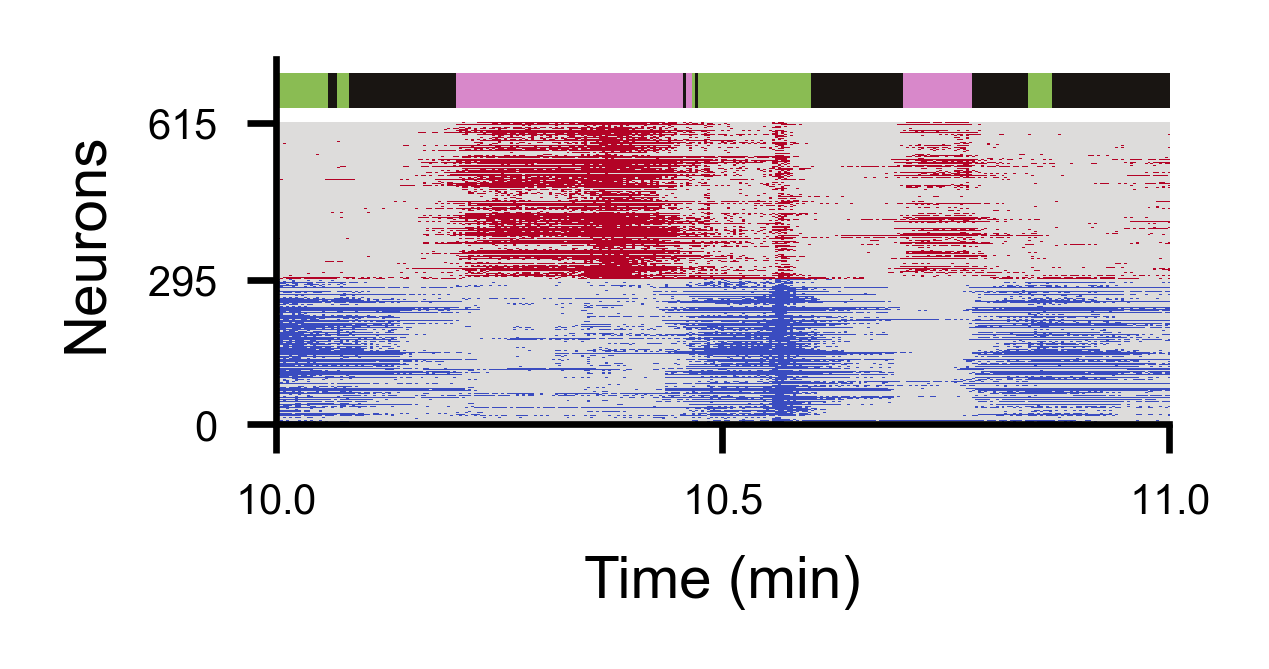

In [214]:
fig, ax = plt.subplots(nrows=1, figsize=(2,1), sharex=True)
t = np.arange(0,len(mL)*dt, dt)
ypad = 30
yext = 100
ax.imshow(
    np.c_[-L.astype(np.int_),R.astype(np.int_)].T, 
    cmap=ARTR_CMAP, vmin=-1, vmax=+1,
    extent=(0, t[-1]/60, 0, L.shape[1] + R.shape[1]),
    rasterized=True,
)
ax.imshow(
    FLR_colors[seq[np.newaxis,:]], 
    extent=(0,t[-1]/60, L.shape[1] + R.shape[1] + ypad,L.shape[1] + R.shape[1] + yext),
    rasterized=True
)
ax.set_ylim(0, L.shape[1] + R.shape[1] + ypad + yext)
ax.set_ylabel("Neurons")
ax.set_xlabel("Time (min)")

ax.set_xlim(10,11)
ax.set_xticks([10,10.5,11])
ax.set_yticks([0,L.shape[1], L.shape[1] + R.shape[1]])
#fig.savefig("panels/Fig6/diag_activity.svg")

## Diffusion

### MSR

In [30]:
from utils.MeanSquaredReorientation import *

In [31]:
qs = np.arange(0,15)

In [32]:
MSR_all = np.empty((len(TEMPS), 6, 2, len(qs))) # ( temp , set , [mean sem] , q )
for t, temp in enumerate(TEMPS):
    DTHETAS = load_sequences(bDATAPATH, temp) # behavior data
    bdtheta,_,_,_ = load_genbehavior(bGENPATH, temp) # generated behavior
    bdtheta = np.array_split(
        bdtheta,
        len(bdtheta) / np.mean([len(a) for a in DTHETAS]),
    )
    DTHETAS_rand = randomize_sequences(DTHETAS) # randomized behavior data
    bdtheta_rand = randomize_sequences(bdtheta) # randomized generated data

    ndtheta = [] # behavior generated from neuro
    for artr in ALL_ARTRs[ALL_ARTRs[:,1] == temp]:
        [ndtheta.append(a) for a in load_genneuro(nGENPATH, *artr)[0]]
    ndtheta_rand = randomize_sequences(ndtheta)

    m = MSRs(DTHETAS, qs)
    MSR_all[t, 0, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSRs(bdtheta, qs)
    MSR_all[t, 1, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSRs(ndtheta, qs)
    MSR_all[t, 2, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSRs(DTHETAS_rand, qs)
    MSR_all[t, 3, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSRs(bdtheta_rand, qs)
    MSR_all[t, 4, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSRs(ndtheta_rand, qs)
    MSR_all[t, 5, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]

Computing MSRs:  14%|████████████████▍                                                                                                  | 76/532 [00:00<00:00, 758.84it/s]/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Computing MSRs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.38it/s]


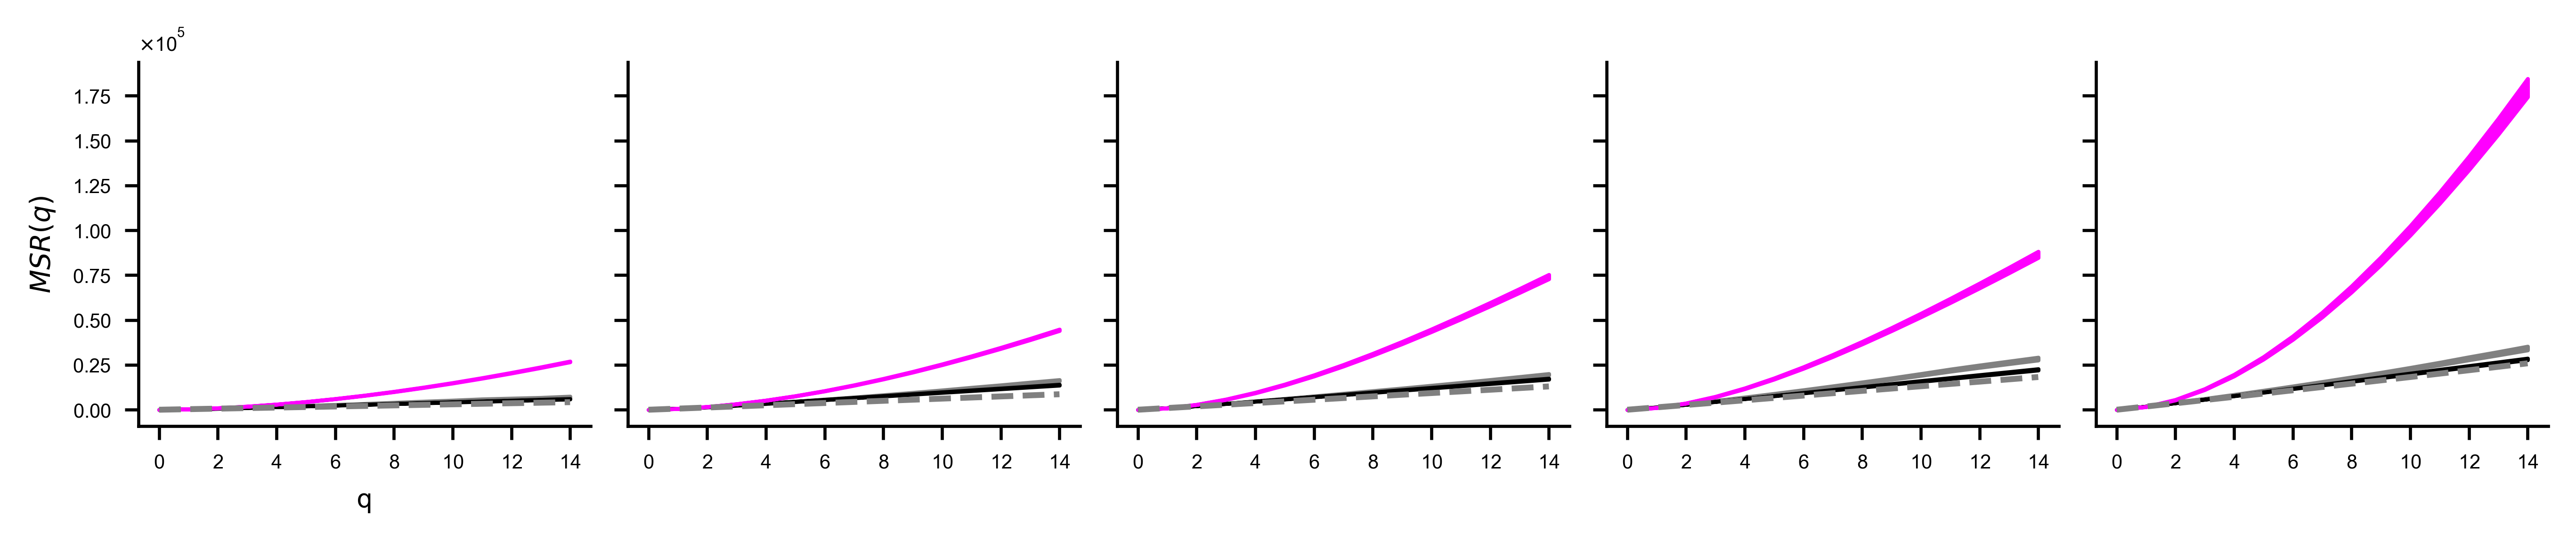

In [33]:
fig, axs = plt.subplots(ncols=len(TEMPS), figsize=(len(TEMPS)*1.8,1.8), sharex=True, sharey=True)

for t, temp in enumerate(TEMPS):
    ax = axs[t]
    ax.fill_between( # behavior data
        qs, 
        MSR_all[t,0,0,:]-MSR_all[t,0,1,:], 
        MSR_all[t,0,0,:]+MSR_all[t,0,1,:],
        color="grey",
    )
    
    ax.fill_between( # generated behavior
        qs, 
        MSR_all[t,1,0,:]-MSR_all[t,1,1,:], 
        MSR_all[t,1,0,:]+MSR_all[t,1,1,:],
        color="k",
    )

    ax.fill_between( # generated behavior from neuro
        qs, MSR_all[t,2,0,:]-MSR_all[t,2,1,:], MSR_all[t,2,0,:]+MSR_all[t,2,1,:],color="magenta")

    ax.plot(qs, MSR_all[t,[3,4], 0].mean(axis=0), linestyle="--", color="grey") # randomized
    #ax.plot(qs, MSR_all[t,5, 0], linestyle="--", color="magenta") # randomized


ax = axs[0]
ax.set_xlabel("q")
ax.set_ylabel("$MSR(q)$")
ax.set_xticks(qs[::2]);
#ax.set_yscale("log")
#ax.set_xscale("log")

(0.0, 4000.0)

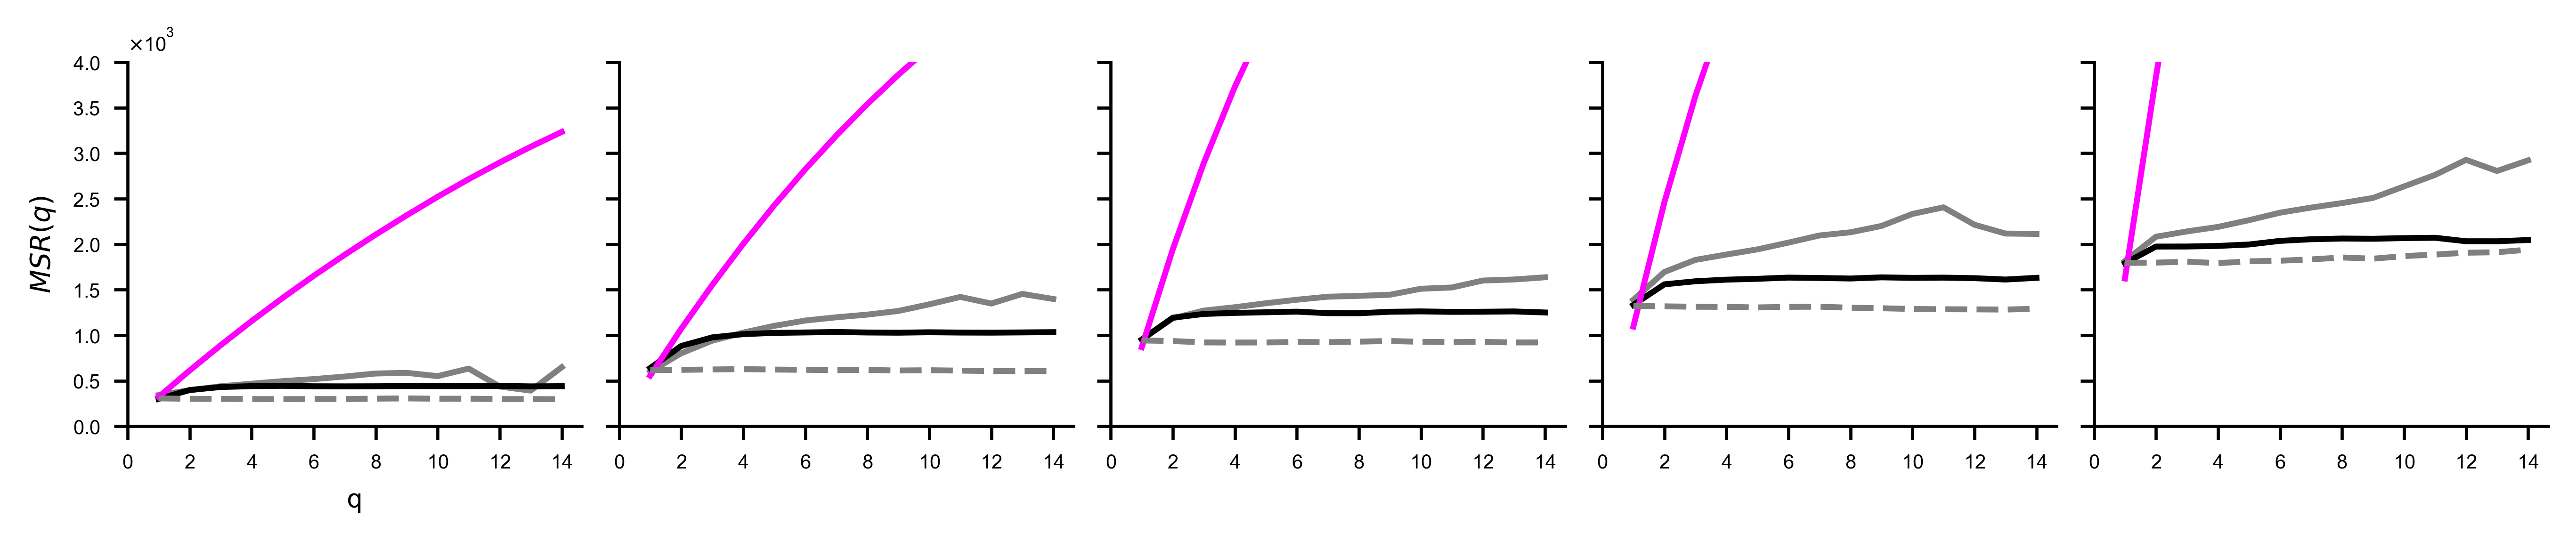

In [34]:
fig, axs = plt.subplots(ncols=len(TEMPS), figsize=(len(TEMPS)*1.8,1.8), sharex=True, sharey=True)

for t, temp in enumerate(TEMPS):
    ax = axs[t]
    ax.plot( # behavior data
        qs[1:], 
        np.diff(MSR_all[t,0,0,:]),
        color="grey",
    )
    
    ax.plot( # generated behavior
        qs[1:], 
        np.diff(MSR_all[t,1,0,:]),
        color="k",
    )

    ax.plot( # generated behavior from neuro
        qs[1:], np.diff(MSR_all[t,2,0,:]),color="magenta")

    ax.plot(qs[1:], np.diff(MSR_all[t,[3,4], 0].mean(axis=0)), linestyle="--", color="grey") # randomized
    #ax.plot(qs, MSR_all[t,5, 0], linestyle="--", color="magenta") # randomized


ax = axs[0]
ax.set_xlabel("q")
ax.set_ylabel("$MSR(q)$")
ax.set_xticks(qs[::2]);
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_ylim(0, 4000)

### MSD

In [188]:
import numpy as np
from tqdm import tqdm

def MSD_q(trajectory, q):
    """Compute the Mean Squared Displacement of a 2D trajectory at a given lag.

    Parameters:
    ------------
    trajectory : 2D array of floats
        A sequence of 2D positions (shape: [N, 2], where N is the number of time steps).
    q : integer
        The lag at which to compute the MSD.

    Returns:
    --------
    m_q : float
        The computed MSD at lag q.
    """
    displacements_squared = []
    for n in range(len(trajectory) - q):
        displacement = trajectory[n + q] - trajectory[n]
        displacement_squared = np.sum(displacement**2)
        displacements_squared.append(displacement_squared)
    m_q = np.mean(displacements_squared)
    return m_q

def MSD(trajectory, qs):
    """Compute the MSD of a 2D trajectory at multiple lags.

    Parameters:
    ------------
    trajectory : 2D array of floats
        A sequence of 2D positions (shape: [N, 2], where N is the number of time steps).
    qs : 1D array of integers
        The lags at which to compute the MSD.

    Returns:
    --------
    msd_qs : 1D array of floats
        The computed MSD at each lag.
    """
    msd_qs = np.empty_like(qs, dtype=np.float_)
    for i, q in enumerate(qs):
        msd_qs[i] = MSD_q(trajectory, q)
    return msd_qs

def MSDs(trajectories, qs):
    """Compute the MSD of multiple 2D trajectories at multiple lags.

    Parameters:
    ------------
    trajectories : list of 2D arrays of floats
        List of 2D trajectories (each of shape: [N, 2]).
    qs : 1D array of integers
        The lags at which to compute the MSD.

    Returns:
    --------
    msd_qs : 2D array of floats
        The computed MSDs for each trajectory at each lag (shape: [len(trajectories), len(qs)]).
    """
    msd_qs = np.empty((len(trajectories), len(qs)), dtype=np.float_)
    for i in tqdm(range(len(trajectories)), desc="Computing MSDs"):
        msd_qs[i] = MSD(trajectories[i], qs)
    return msd_qs

def randomize_trajectories(trajectories):
    """Randomize the 2D trajectories by shuffling all positions across all trajectories.
    
    The output shape will match the input (num_trajectories, trajectory_length, 2).

    Parameters:
    ------------
    trajectories : list of 2D arrays of floats
        List of 2D trajectories (each of shape: [N, 2]).

    Returns:
    --------
    randomized_trajectories : 3D array of floats
        Randomized 2D trajectories (shape: [num_trajectories, trajectory_length, 2]).
    """
    # Extract the lengths of each trajectory
    lengths = [len(traj) for traj in trajectories]
    num_trajectories = len(trajectories)

    # Concatenate all trajectories into one large array of shape (total_positions, 2)
    long_trajectory = np.vstack(trajectories)  # Concatenate all trajectories into one long array

    # Shuffle the concatenated positions randomly
    shuffled_trajectory = np.random.permutation(long_trajectory)  # Shuffle all positions

    # Split the shuffled positions back into randomized trajectories with the same lengths
    randomized_trajectories = []
    start_idx = 0
    for length in lengths:
        randomized_trajectories.append(shuffled_trajectory[start_idx:start_idx + length])
        start_idx += length

    # Convert the list of arrays back to a 3D numpy array (num_trajectories, length_of_each_trajectory, 2)
    return np.array(randomized_trajectories)

def load_trajs(path, temp):
    file = h5py.File(path, "r")
    grp = file[f"behaviour/{temp}"]
    #bangle = format_sequences(grp["dtheta"][()])
    xpos = format_sequences(grp["xpos"][()])
    ypos = format_sequences(grp["ypos"][()])
    file.close()
    return [np.c_[x, y] for x, y in zip(xpos, ypos)]

In [ ]:
bdtheta,_,bdist,_ = load_genbehavior(bGENPATH, temp)
bxypos = np.c_[reconstruct_trajs(bdtheta, bdist)]
bxypos = np.array_split(bxypos, len(XYPOS) / np.mean([len(a) for a in XYPOS]), axis=0)
MSDs(bxypos, qs)

In [213]:
MSD_all = np.empty((len(TEMPS), 6, 2, len(qs))) # ( temp , set , [mean sem] , q )
for t, temp in enumerate(TEMPS):
    XYPOS = load_trajs(bDATAPATH, temp) # behavior data
    bdtheta,_,bdist,_ = load_genbehavior(bGENPATH, temp) # generated behavior
    bxypos = np.c_[reconstruct_trajs(bdtheta, bdist)]
    bxypos = np.array_split(bxypos, len(XYPOS) / np.mean([len(a) for a in XYPOS]), axis=0)
    
    #XYPOS_rand = randomize_sequences(DTHETAS) # randomized behavior data
    #bxypos_rand = randomize_sequences(bxypos) # randomized generated data
    #ndtheta = [] # behavior generated from neuro
    #for artr in ALL_ARTRs[ALL_ARTRs[:,1] == temp]:
    #    [ndtheta.append(a) for a in load_genneuro(nGENPATH, *artr)[0]]
    #ndtheta_rand = randomize_sequences(ndtheta)

    m = MSDs(XYPOS, qs)
    MSD_all[t, 0, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    m = MSDs(bxypos, qs)
    MSD_all[t, 1, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    #m = MSRs(ndtheta, qs)
    #MSR_all[t, 2, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    #m = MSRs(XYPOS_rand, qs)
    #MSD_all[t, 3, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    #m = MSRs(bdtheta_rand, qs)
    #MSR_all[t, 4, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]
    
    #m = MSRs(ndtheta_rand, qs)
    #MSR_all[t, 5, :] = [np.nanmean(m,axis=0), np.nanstd(m,axis=0)/np.sqrt(m.shape[0])]

Computing MSDs:  27%|████████████████████████████████████████████████▌                                                                                                                                      | 141/532 [00:00<00:01, 249.91it/s]/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ZebrafishHMM2024/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Computing MSDs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:08<00:00,  2.66it/s]


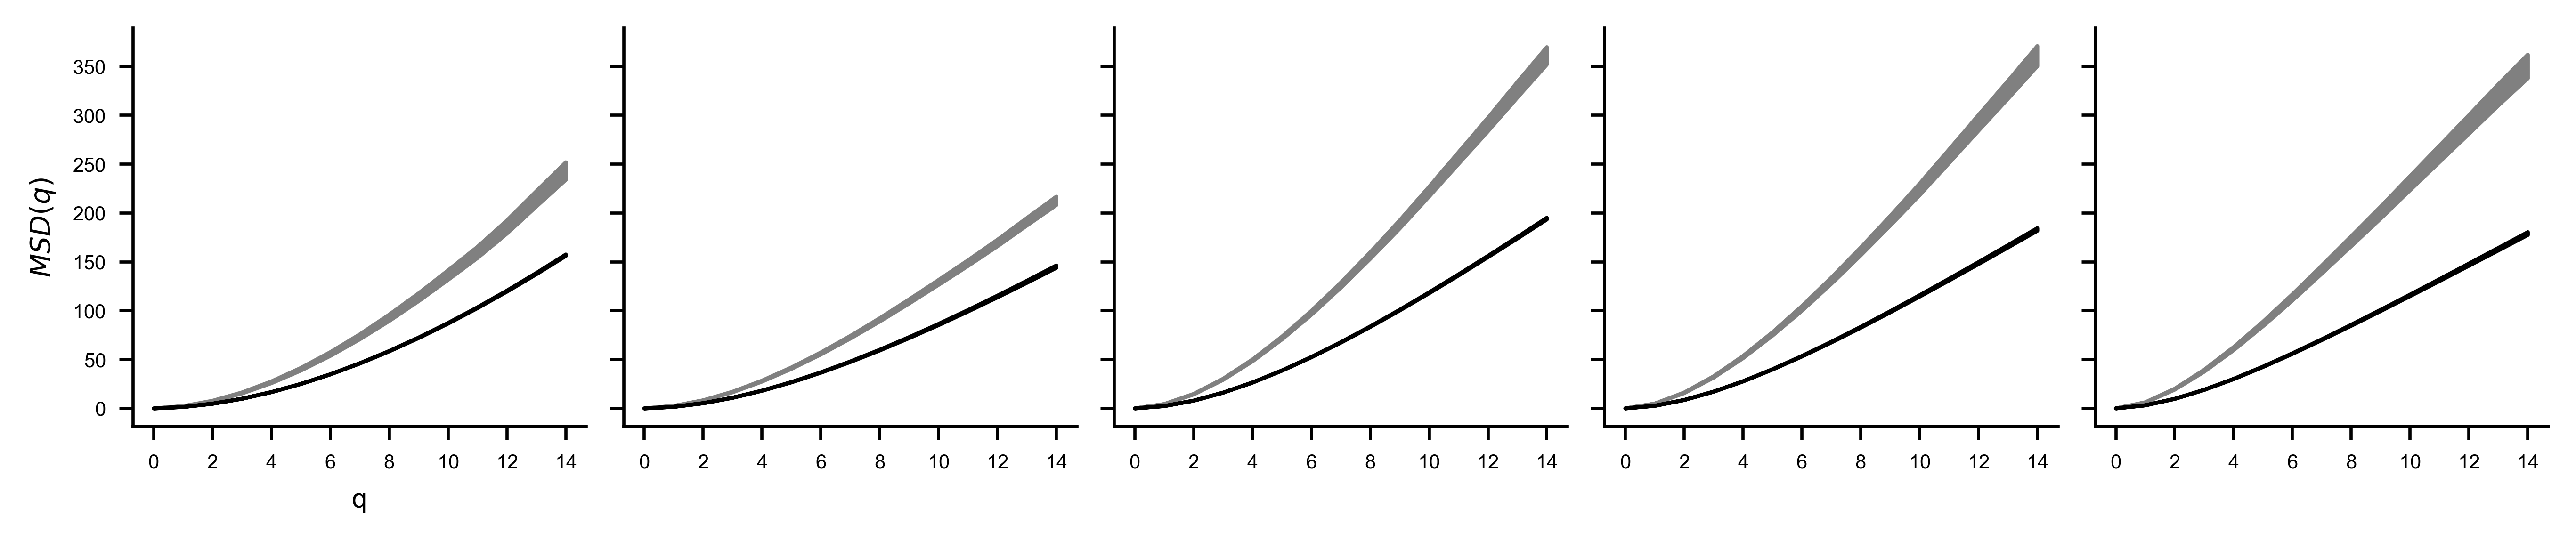

In [214]:
fig, axs = plt.subplots(ncols=len(TEMPS), figsize=(len(TEMPS)*1.8,1.8), sharex=True, sharey=True)

for t, temp in enumerate(TEMPS):
    ax = axs[t]
    ax.fill_between( # behavior data
        qs, 
        MSD_all[t,0,0,:]-MSD_all[t,0,1,:], 
        MSD_all[t,0,0,:]+MSD_all[t,0,1,:],
        color="grey",
    )
    
    ax.fill_between( # generated behavior
        qs, 
        MSD_all[t,1,0,:]-MSD_all[t,1,1,:], 
        MSD_all[t,1,0,:]+MSD_all[t,1,1,:],
        color="k",
    )

    #ax.fill_between( # generated behavior from neuro
    #    qs, MSR_all[t,2,0,:]-MSR_all[t,2,1,:], MSR_all[t,2,0,:]+MSR_all[t,2,1,:],color="magenta")

    #ax.plot(qs, MSD_all[t,3,0], linestyle="--", color="grey") # randomized
    #ax.plot(qs, MSR_all[t,[3,4], 0].mean(axis=0), linestyle="--", color="grey") # randomized
    #ax.plot(qs, MSR_all[t,5, 0], linestyle="--", color="magenta") # randomized


ax = axs[0]
ax.set_xlabel("q")
ax.set_ylabel("$MSD(q)$")
ax.set_xticks(qs[::2]);
#ax.set_yscale("log")
#ax.set_xscale("log")

In [412]:
1/0.44, 1/(0.44**2)

(2.272727272727273, 5.1652892561983474)

In [5]:
BT, bT, nT0, nT1, nT2 = [], [], [], [], []
for temp in TEMPS:
    BT.append(load_transmat(bMODELPATH, "g3", temp))

    bangle, bdt, bdist, bstate = load_genbehavior(bGENPATH, temp)
    bT.append(MC.bout_transitions([bstate]))

    T0, T1, T2 = [], [], []
    for artr in ALL_ARTRs[ALL_ARTRs[:,1] == temp]:
        nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
        T0.append(MC.bout_transitions(nstate))
        T1.append(np.linalg.matrix_power(MC.bout_transitions(nstate), 2))
        T2.append(np.linalg.matrix_power(MC.bout_transitions(nstate), 5))
    nT0.append(np.array(T0))
    nT1.append(np.array(T1))
    nT2.append(np.array(T2))

BT = np.array(BT)
bT = np.array(bT)
nT0 = np.array([[T.mean(axis=0),T.std(axis=0)/np.sqrt(len(T))] for T in nT0])
nT1 = np.array([[T.mean(axis=0),T.std(axis=0)/np.sqrt(len(T))] for T in nT1])
nT2 = np.array([[T.mean(axis=0),T.std(axis=0)/np.sqrt(len(T))] for T in nT2])

Text(0, 0.5, "$P(b|b')$ - Generated Behavior/Neuro")

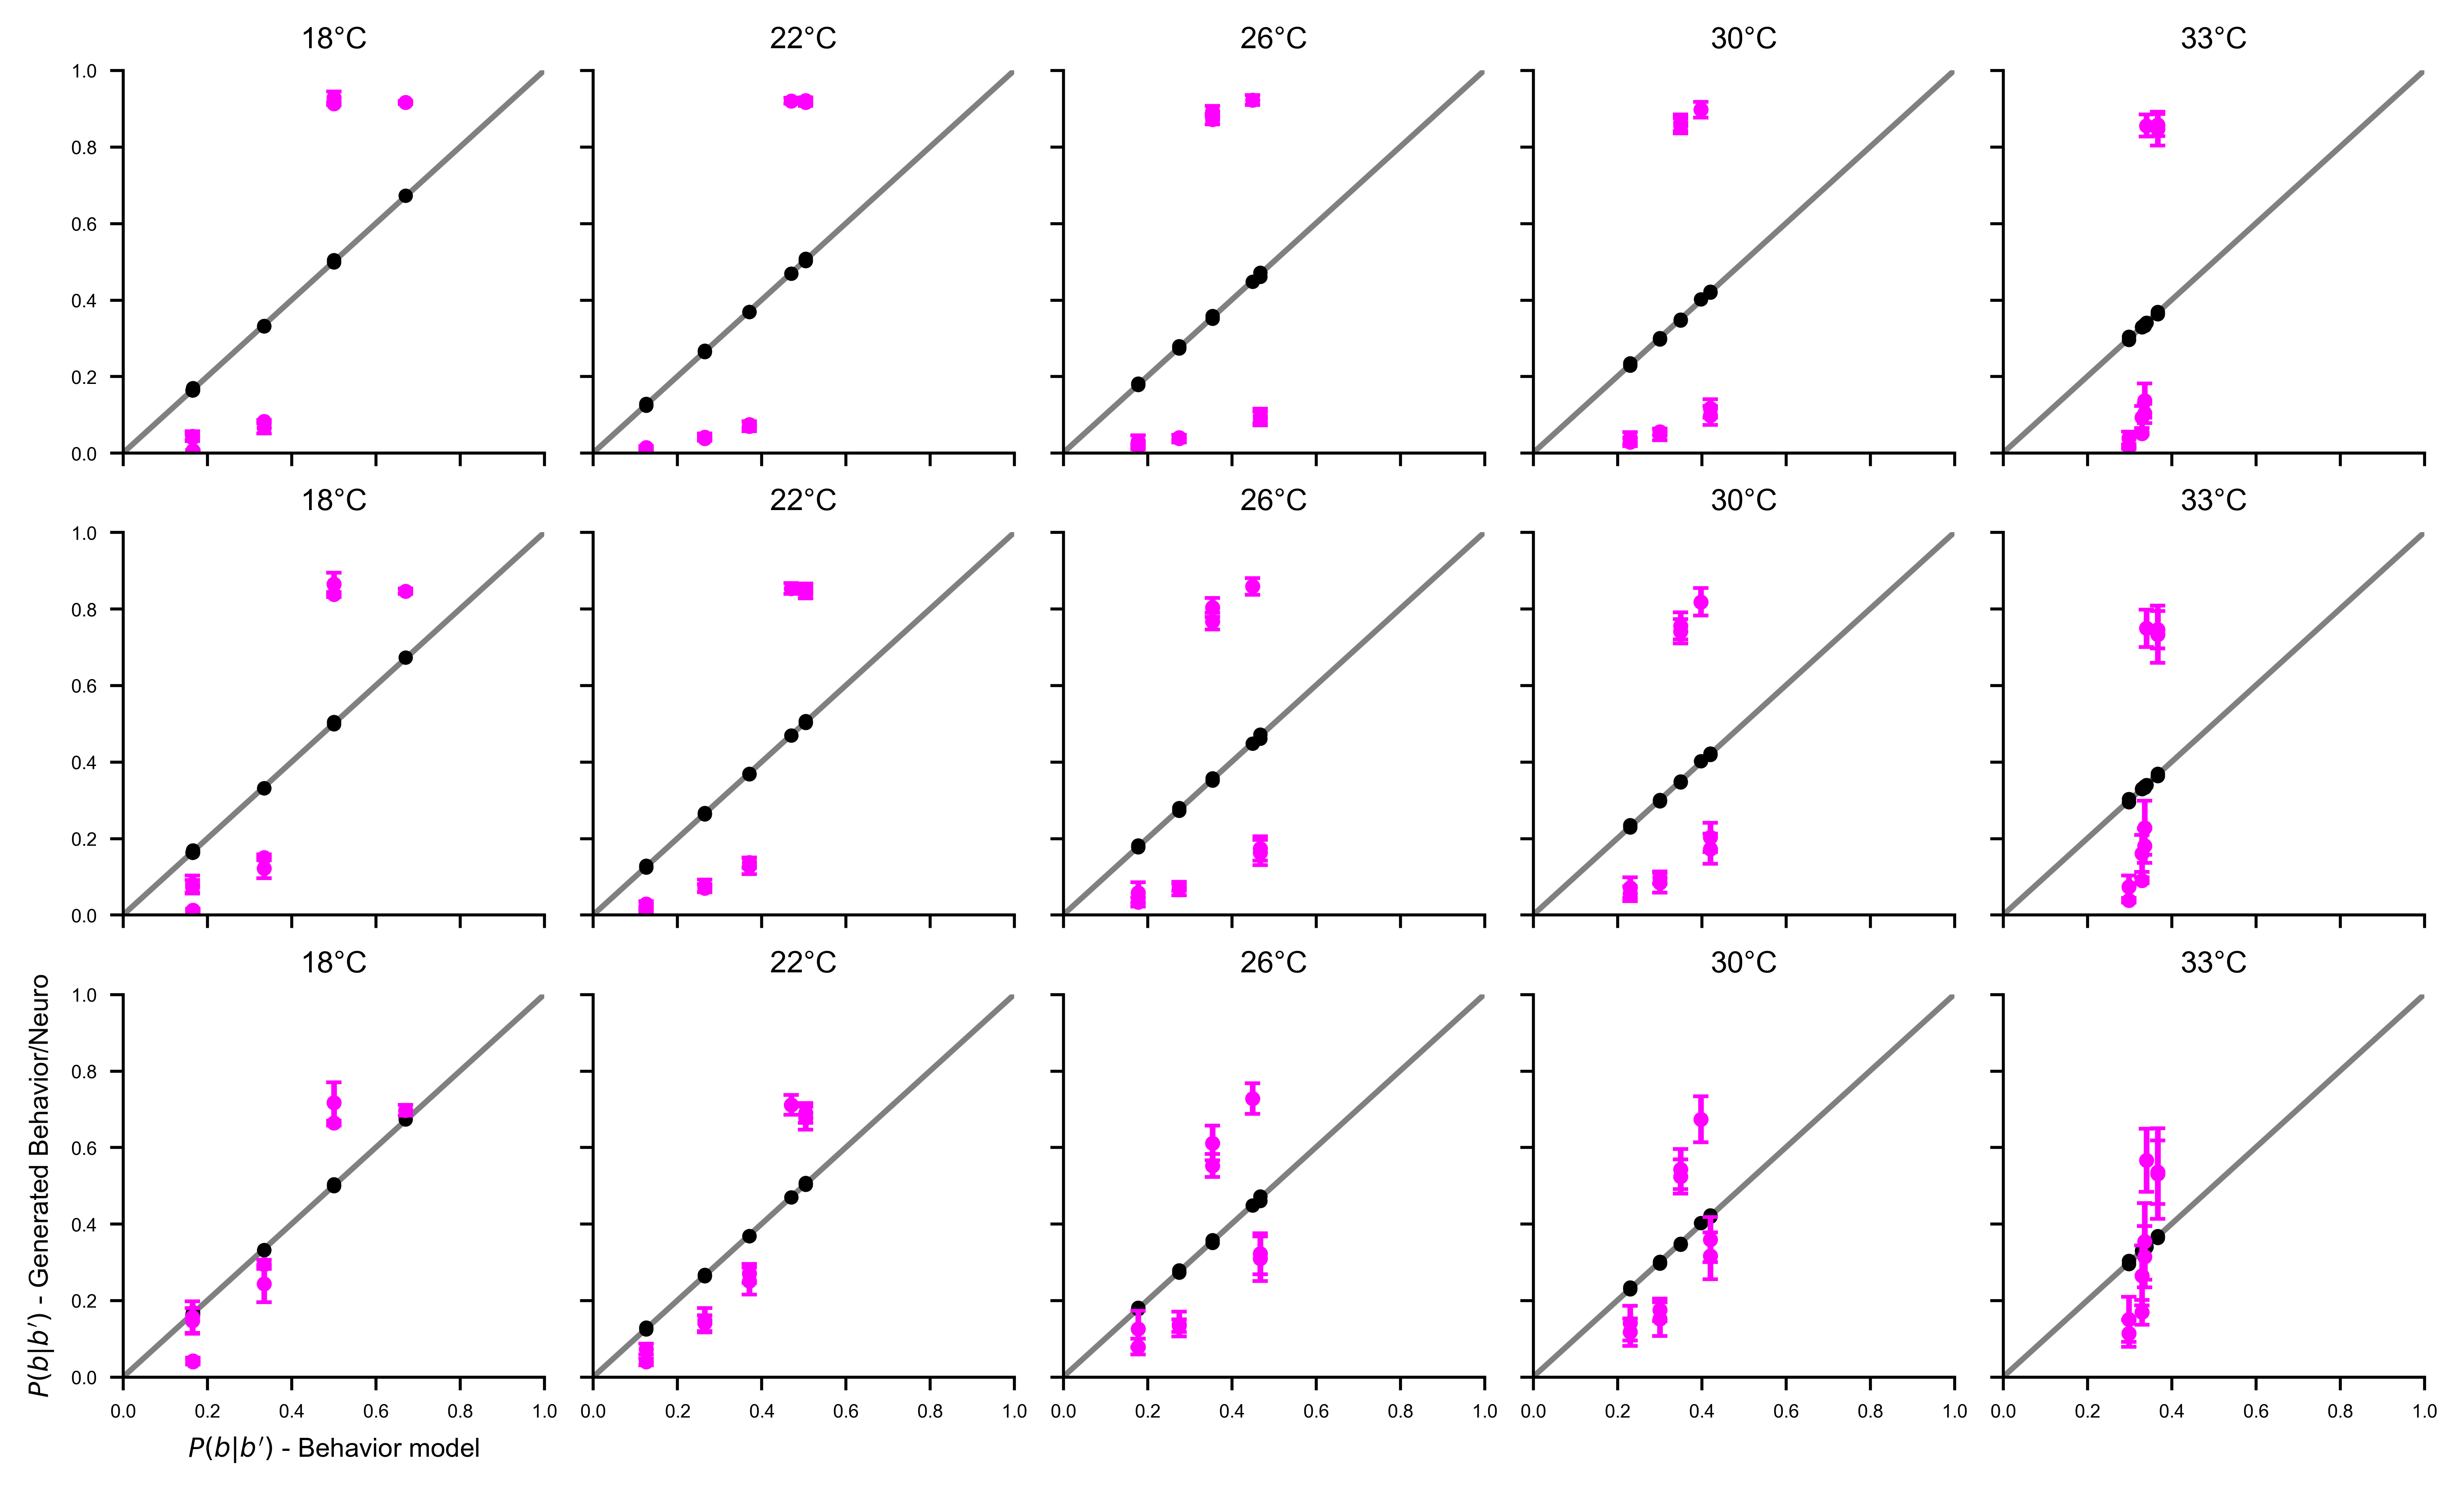

In [6]:
fig, axs = plt.subplots(ncols=len(TEMPS), nrows=3, figsize=(len(TEMPS)*1.8, 3*1.8), sharex=True, sharey=True)

for t, temp, ax in zip(range(len(TEMPS)), TEMPS, axs[0]):
    ax.set_title(f"{temp}°C")
    ax.plot([0,1], [0,1], color="grey", zorder=0)
    ax.scatter(BT[t].ravel(), bT[t].ravel(), color="k", s=8)
    ax.errorbar(BT[t].ravel(), nT0[t,0].ravel(), yerr=nT0[t,1].ravel(), fmt="o", markersize=3, color="magenta", capsize=2)

for t, temp, ax in zip(range(len(TEMPS)), TEMPS, axs[1]):
    ax.set_title(f"{temp}°C")
    ax.plot([0,1], [0,1], color="grey", zorder=0)
    ax.scatter(BT[t].ravel(), bT[t].ravel(), color="k", s=8)
    ax.errorbar(BT[t].ravel(), nT1[t,0].ravel(), yerr=nT1[t,1].ravel(), fmt="o", markersize=3, color="magenta", capsize=2)

for t, temp, ax in zip(range(len(TEMPS)), TEMPS, axs[2]):
    ax.set_title(f"{temp}°C")
    ax.plot([0,1], [0,1], color="grey", zorder=0)
    ax.scatter(BT[t].ravel(), bT[t].ravel(), color="k", s=8)
    ax.errorbar(BT[t].ravel(), nT2[t,0].ravel(), yerr=nT2[t,1].ravel(), fmt="o", markersize=3, color="magenta", capsize=2)

ax = axs[-1,0]
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("$P(b|b')$ - Behavior model")
ax.set_ylabel("$P(b|b')$ - Generated Behavior/Neuro")

In [38]:
diagi, diagj = np.diag_indices(3)
L1 = -1/np.log(BT[:,diagi, diagj])
bL1 = -1/np.log(bT[:,diagi, diagj])

In [39]:
n0L1 = -1/np.log(nT0[:,0,diagi,diagj])
n1L1 = -1/np.log(nT1[:,0,diagi,diagj])
n2L1 = -1/np.log(nT2[:,0,diagi,diagj])

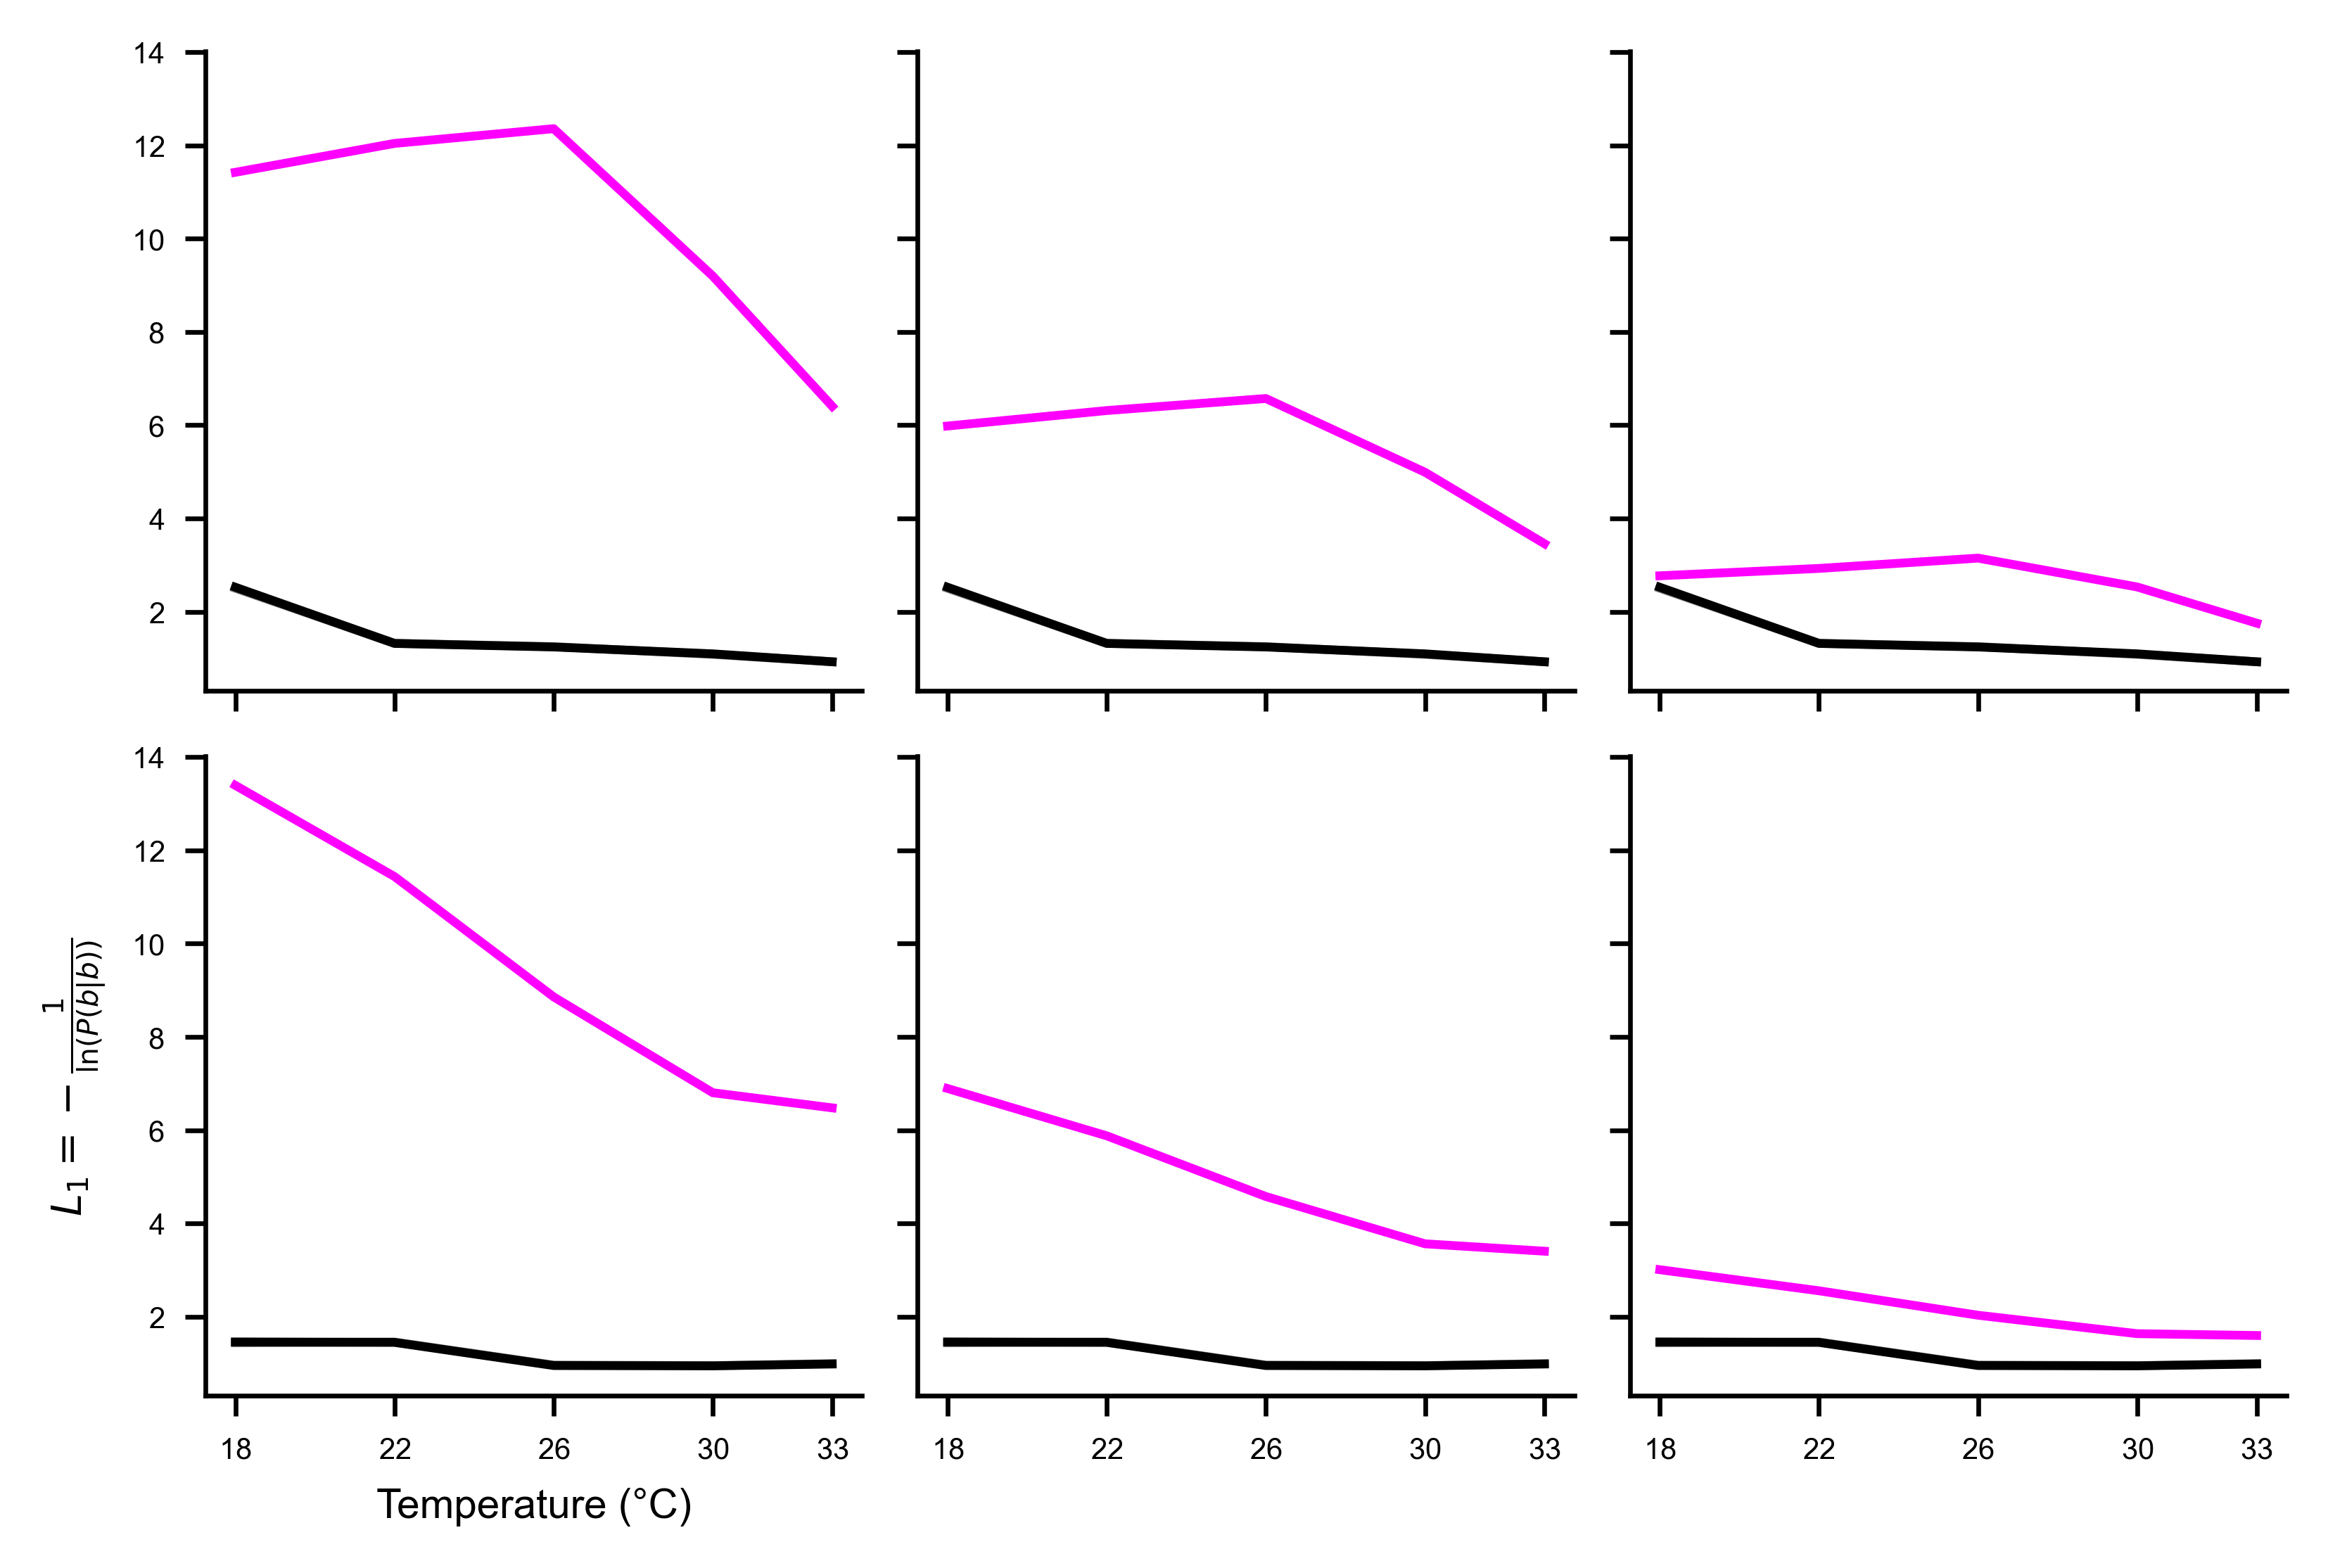

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*1.8, 2*1.8), sharex=True, sharey=True)

ax = axs[0,0]
ax.plot(TEMPS, L1[:,0], color="grey")
ax.plot(TEMPS, bL1[:,0], color="k")
ax.plot(TEMPS, n0L1[:,0], color="magenta")

ax = axs[1,0]
ax.plot(TEMPS, L1[:,1], color="grey")
ax.plot(TEMPS, bL1[:,1], color="k")
ax.plot(TEMPS, n0L1[:,1], color="magenta")
ax.set_ylabel(r"$L_1 = -\frac{1}{\ln( P(b|b))}$")
ax.set_xticks(TEMPS)
ax.set_xlabel("Temperature (°C)")

ax = axs[0,1]
ax.plot(TEMPS, L1[:,0], color="grey")
ax.plot(TEMPS, bL1[:,0], color="k")
ax.plot(TEMPS, n1L1[:,0], color="magenta")

ax = axs[1,1]
ax.plot(TEMPS, L1[:,1], color="grey")
ax.plot(TEMPS, bL1[:,1], color="k")
ax.plot(TEMPS, n1L1[:,1], color="magenta")

ax = axs[0,2]
ax.plot(TEMPS, L1[:,0], color="grey")
ax.plot(TEMPS, bL1[:,0], color="k")
ax.plot(TEMPS, n2L1[:,0], color="magenta")

ax = axs[1,2]
ax.plot(TEMPS, L1[:,1], color="grey")
ax.plot(TEMPS, bL1[:,1], color="k")
ax.plot(TEMPS, n2L1[:,1], color="magenta")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

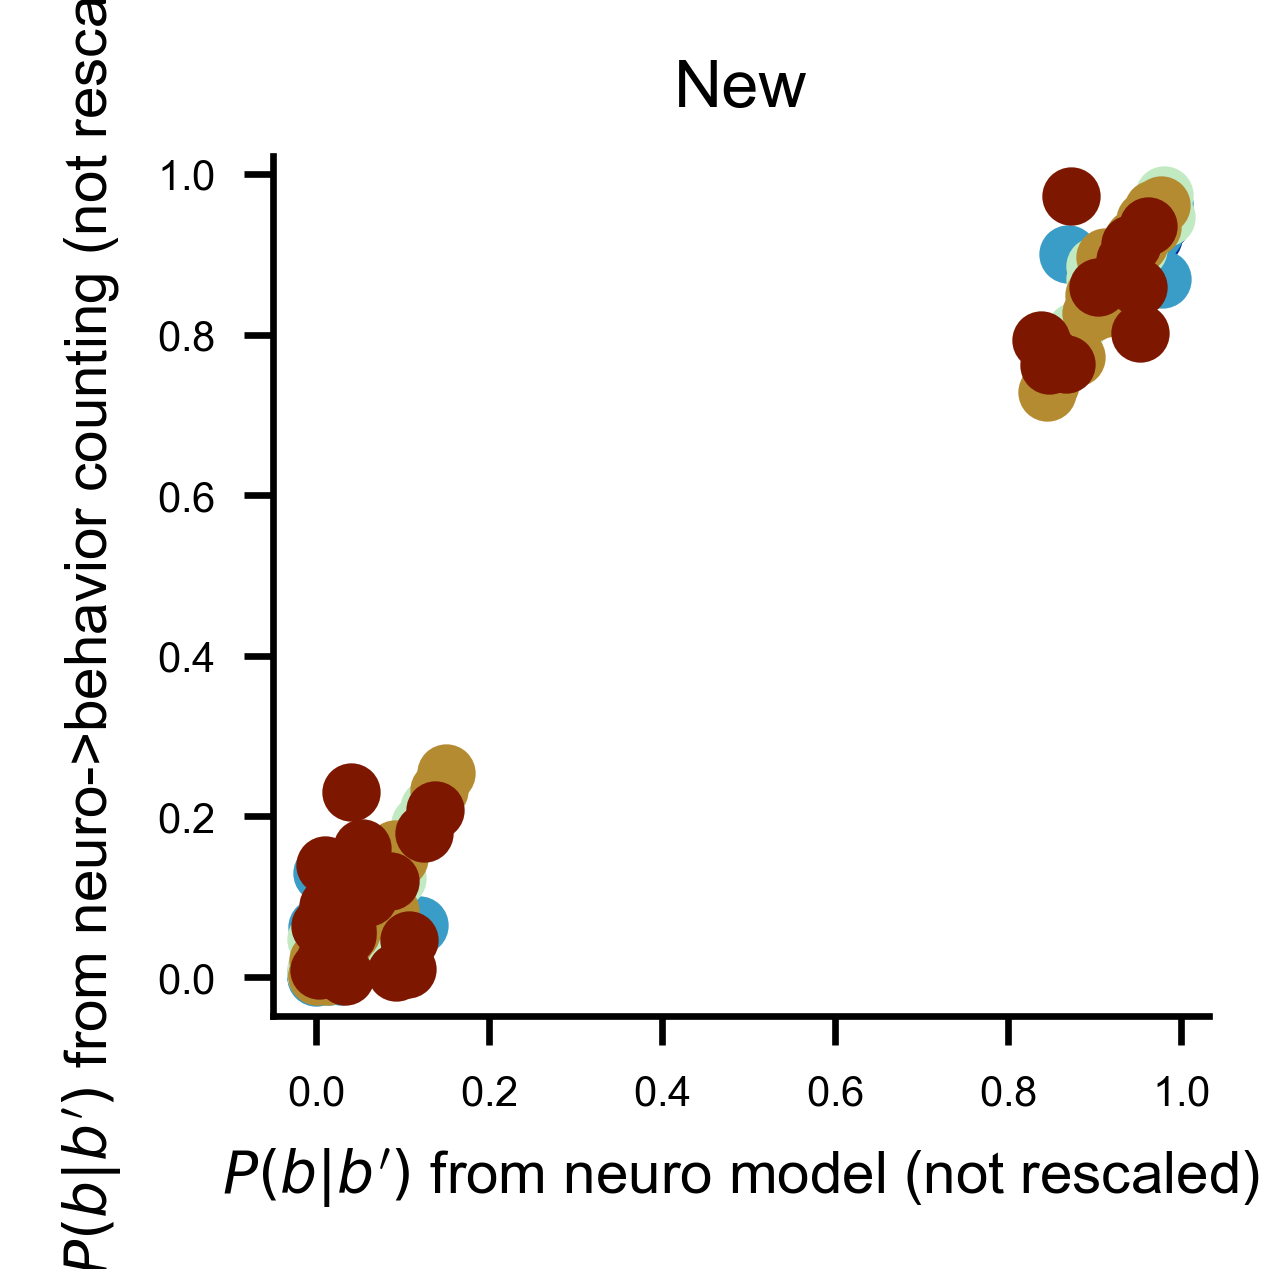

In [22]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR6/")
fig, ax = plt.subplots()
ax.set_title("New")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (not rescaled)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

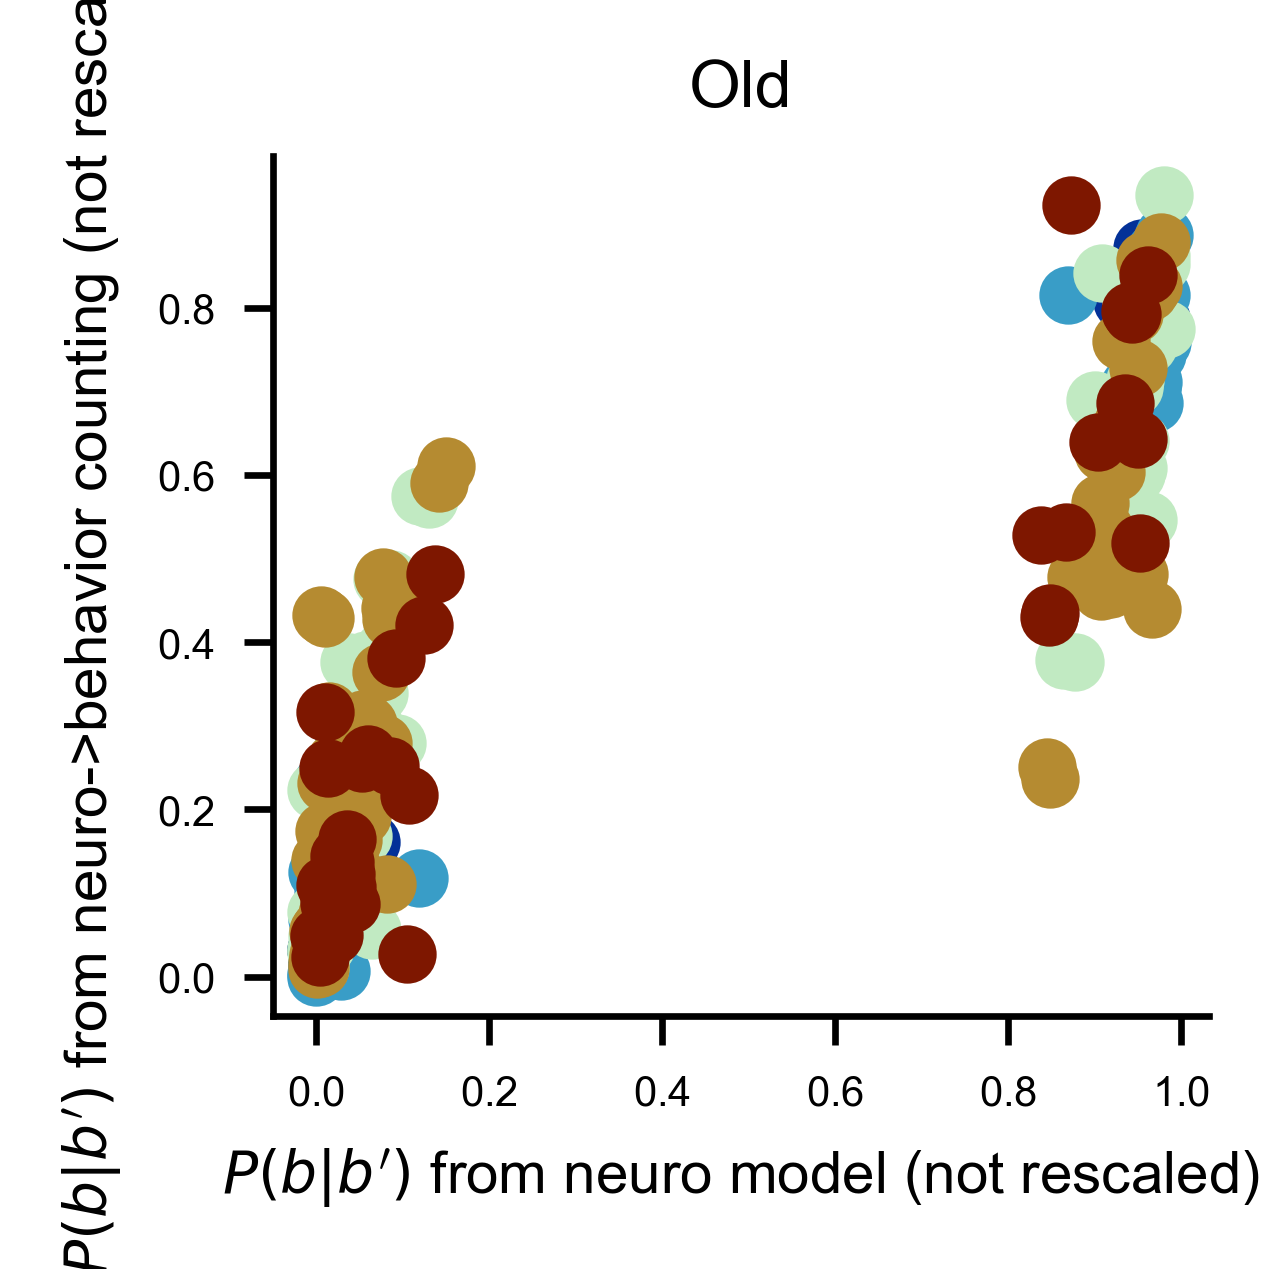

In [23]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR5/")
fig, ax = plt.subplots()
ax.set_title("Old")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (not rescaled)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

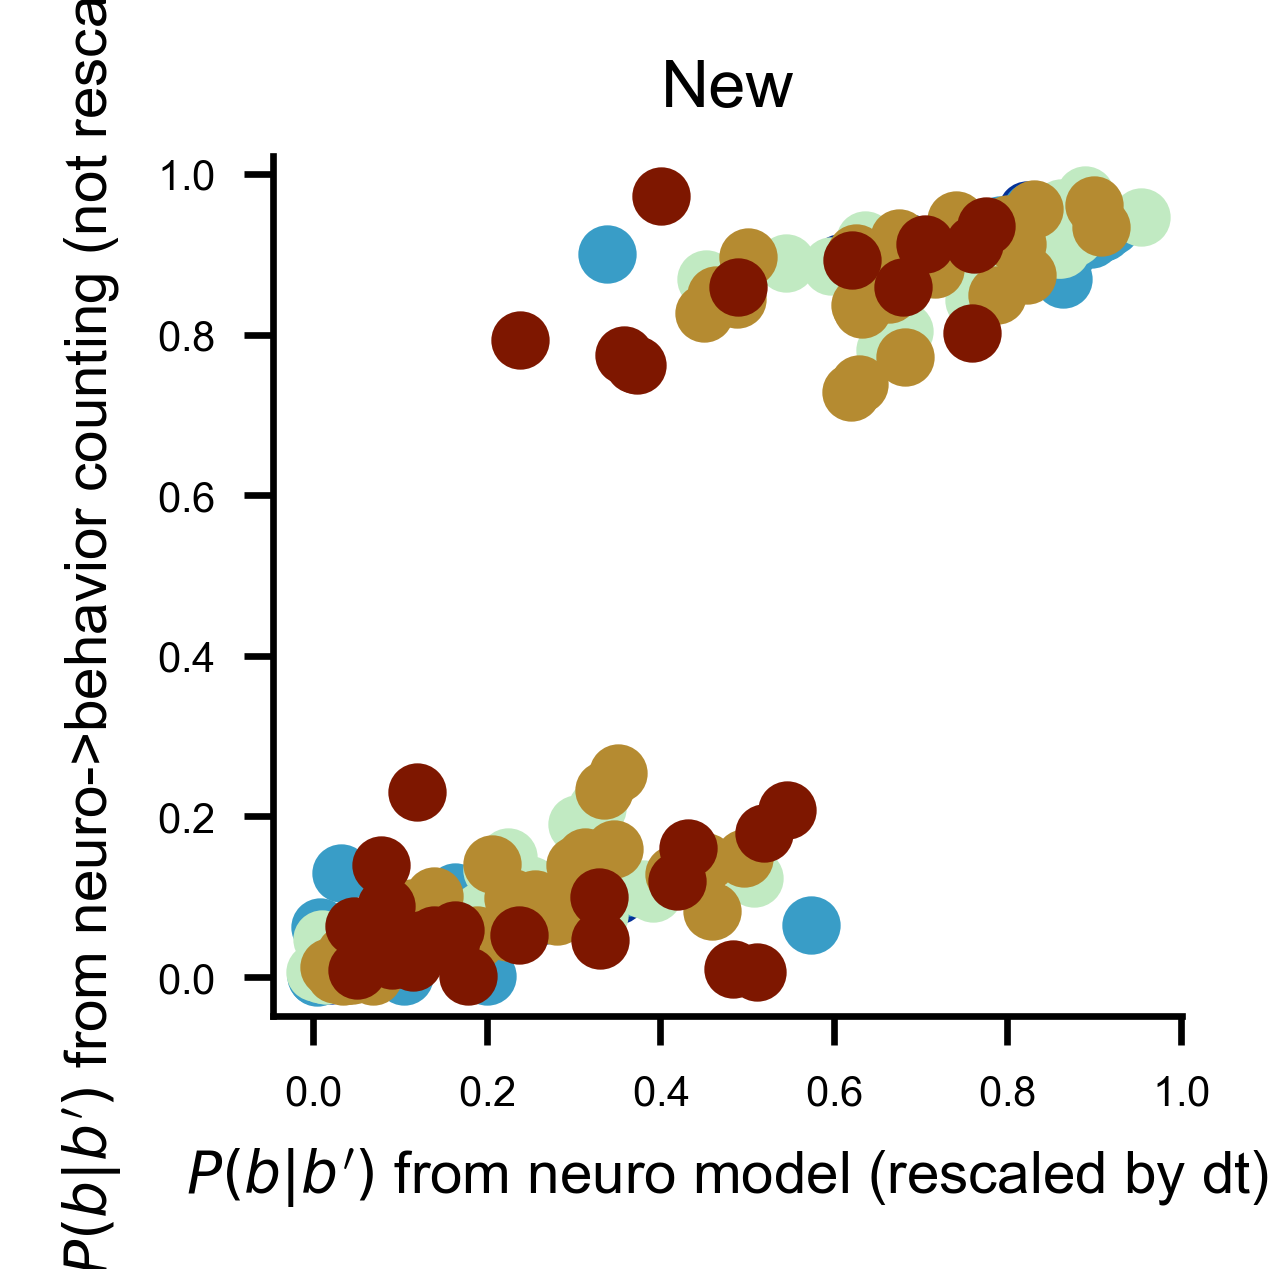

In [26]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR6/")
fig, ax = plt.subplots()
ax.set_title("New")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/dt))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by dt)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

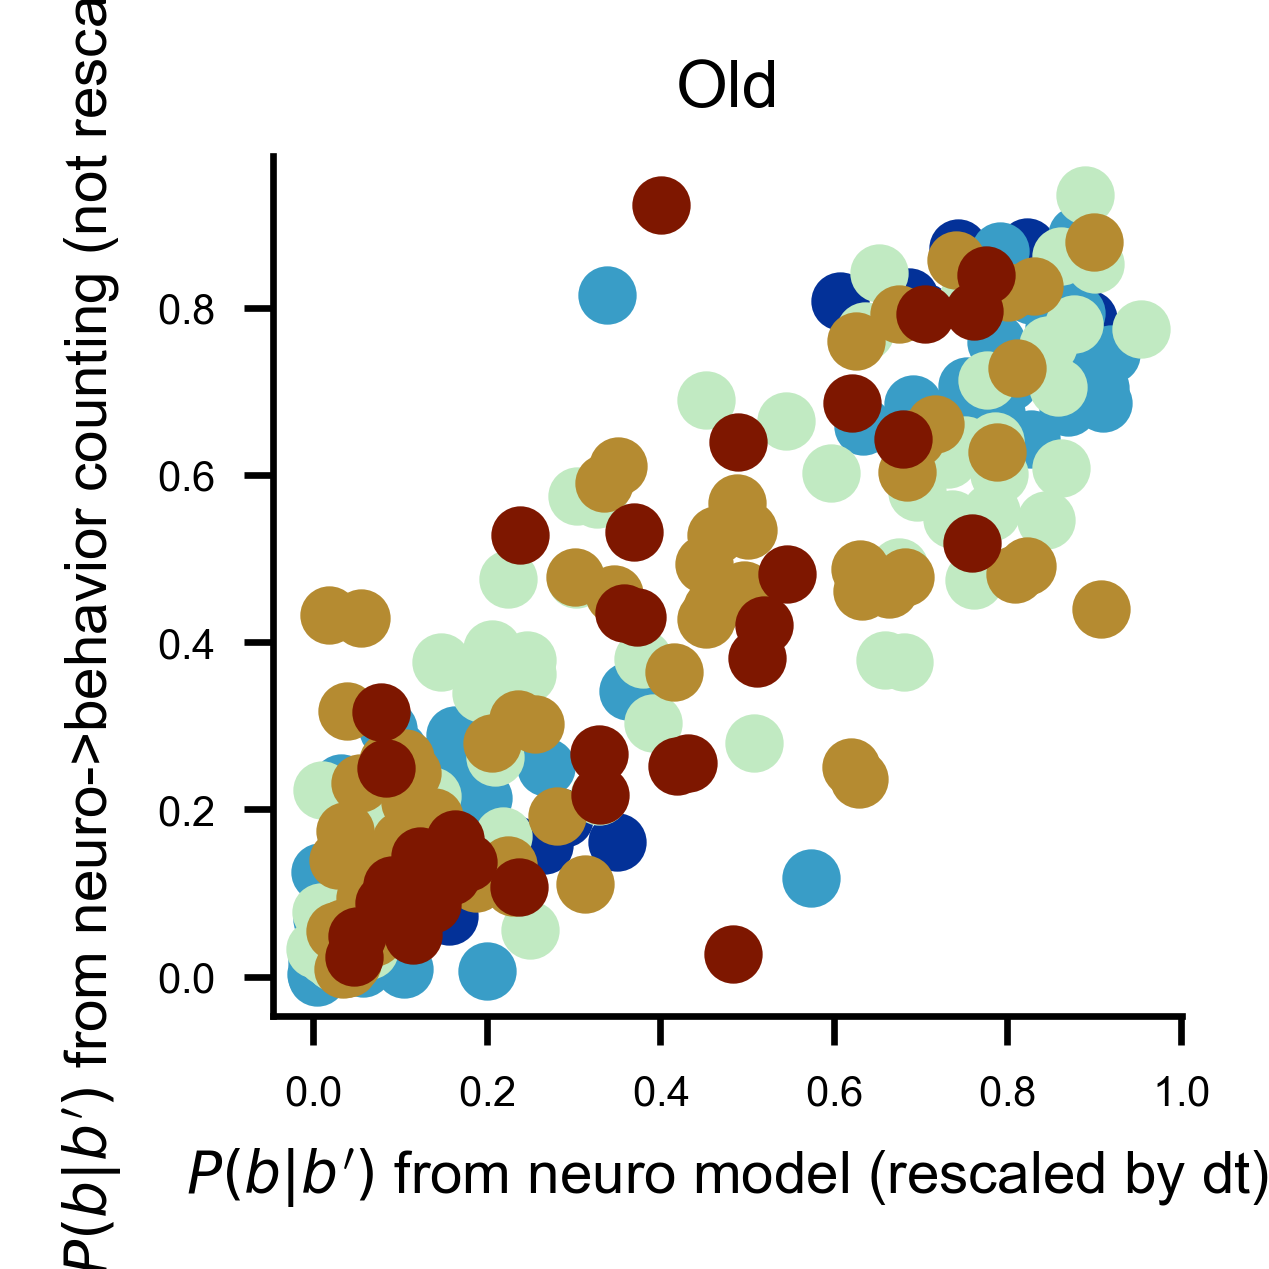

In [27]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR5/")
fig, ax = plt.subplots()
ax.set_title("Old")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/dt))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by dt)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

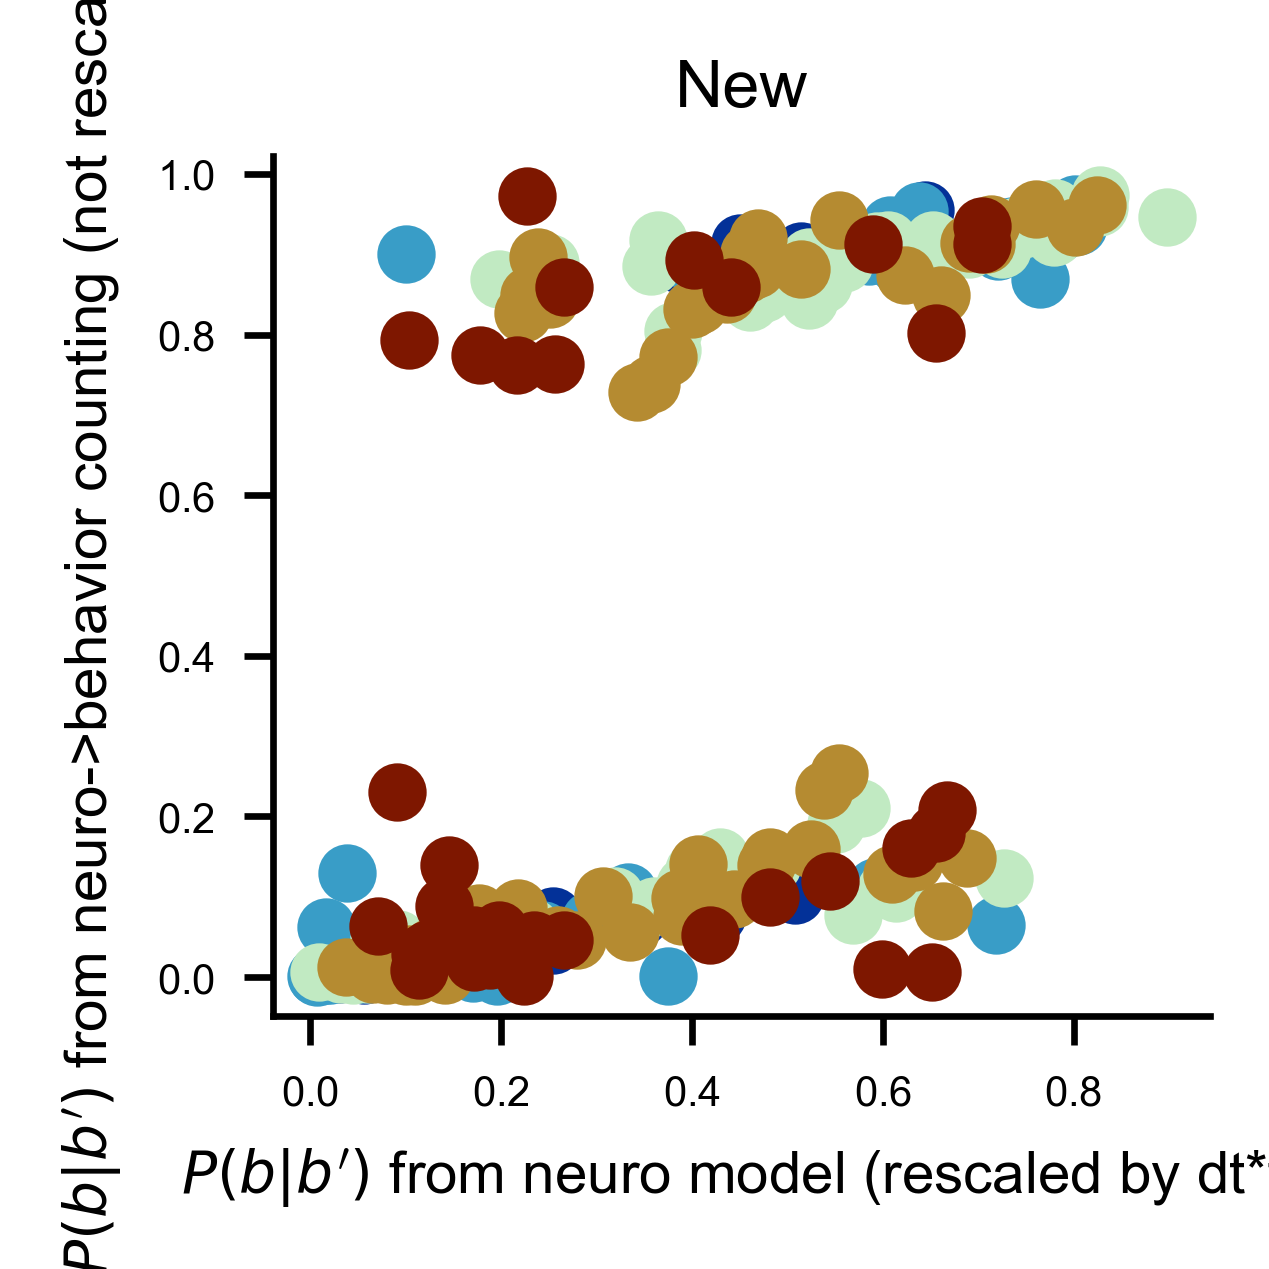

In [28]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR6/")
fig, ax = plt.subplots()
ax.set_title("New")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/(dt*0.44)))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by dt*f)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

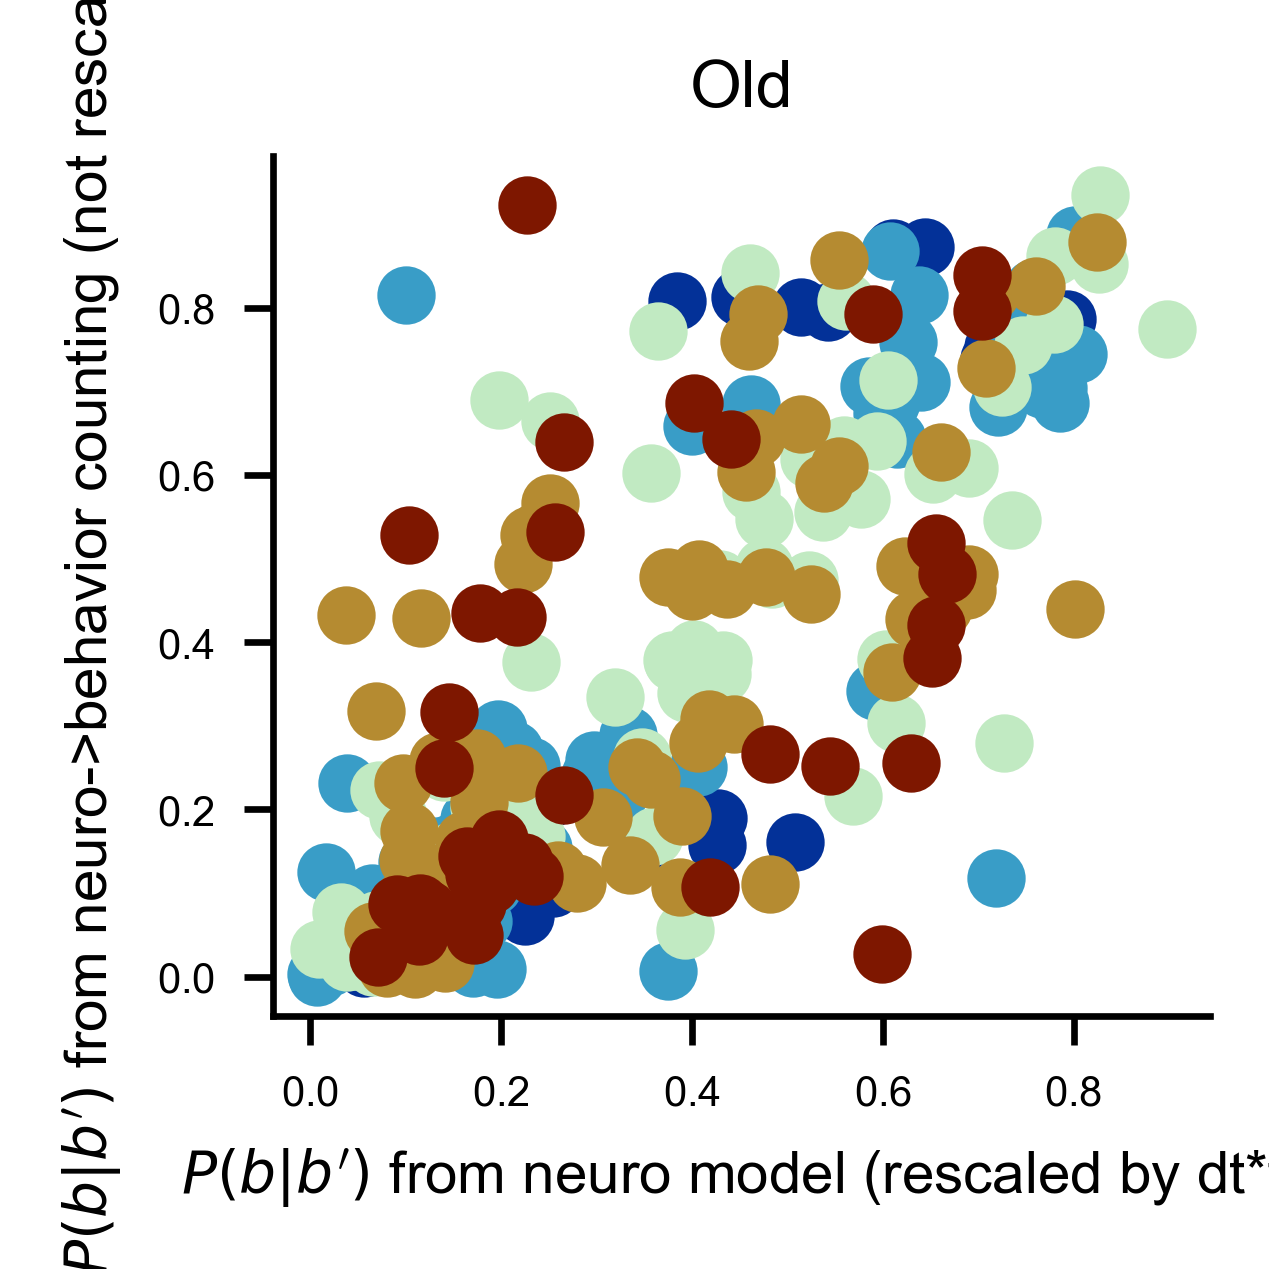

In [29]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR5/")
fig, ax = plt.subplots()
ax.set_title("Old")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/(dt*0.44)))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by dt*f)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

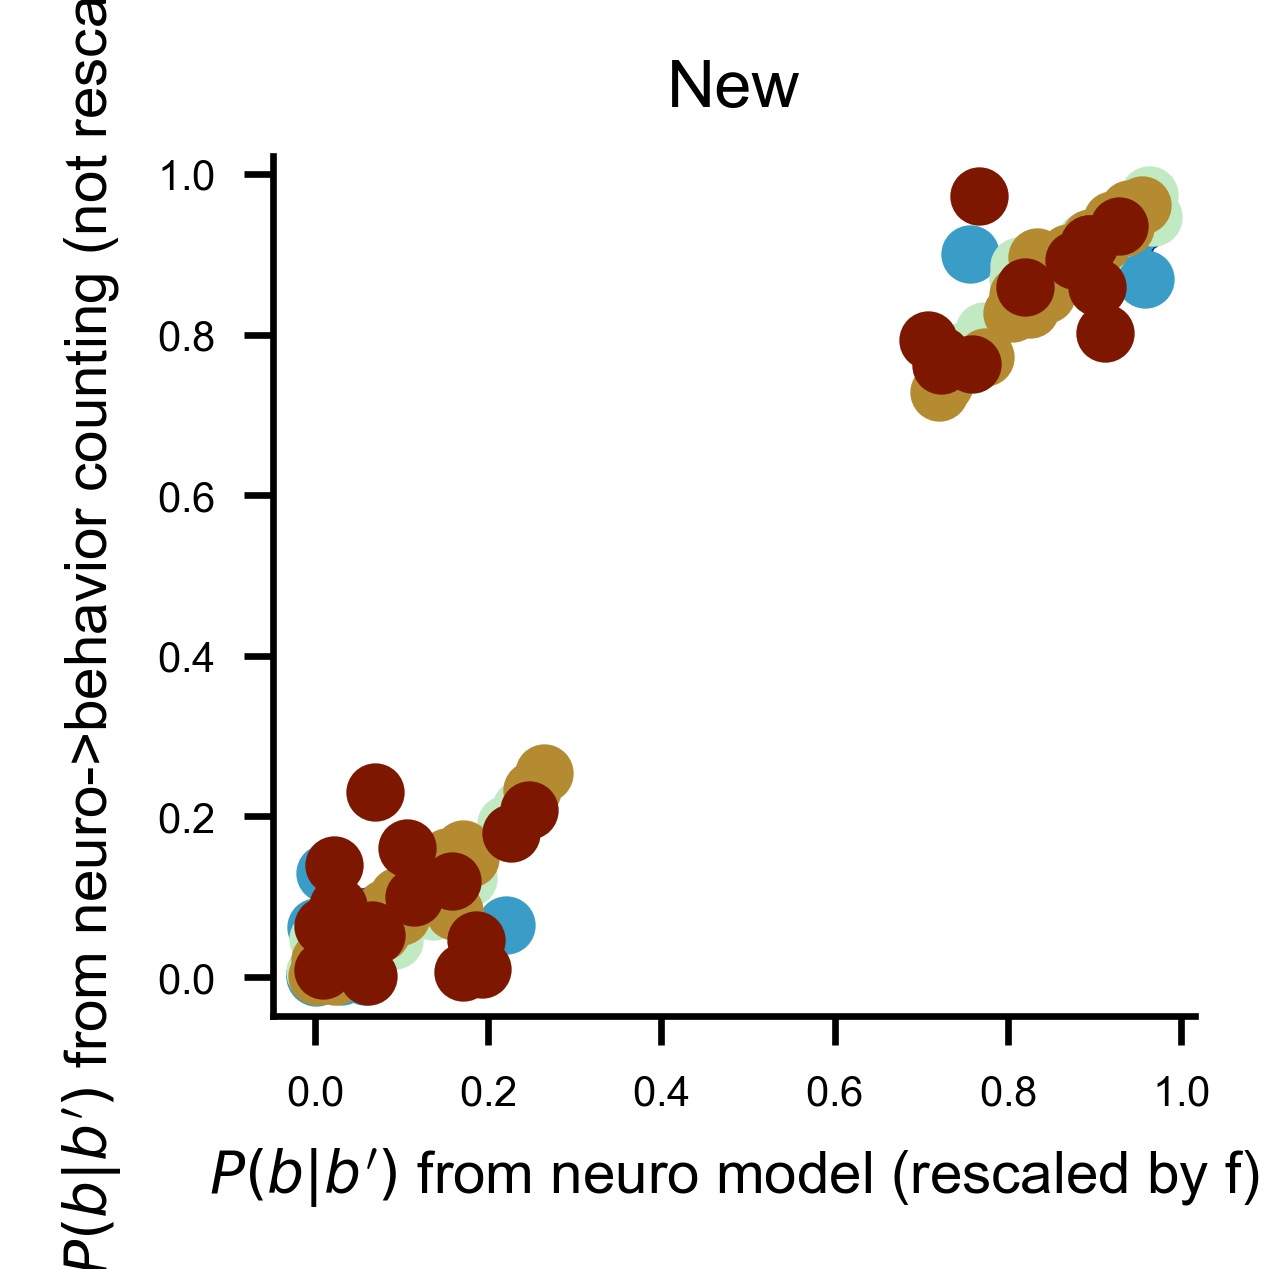

In [30]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR6/")
fig, ax = plt.subplots()
ax.set_title("New")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/(0.44)))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by f)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

Text(0, 0.5, "$P(b|b')$ from neuro->behavior counting (not rescaled)")

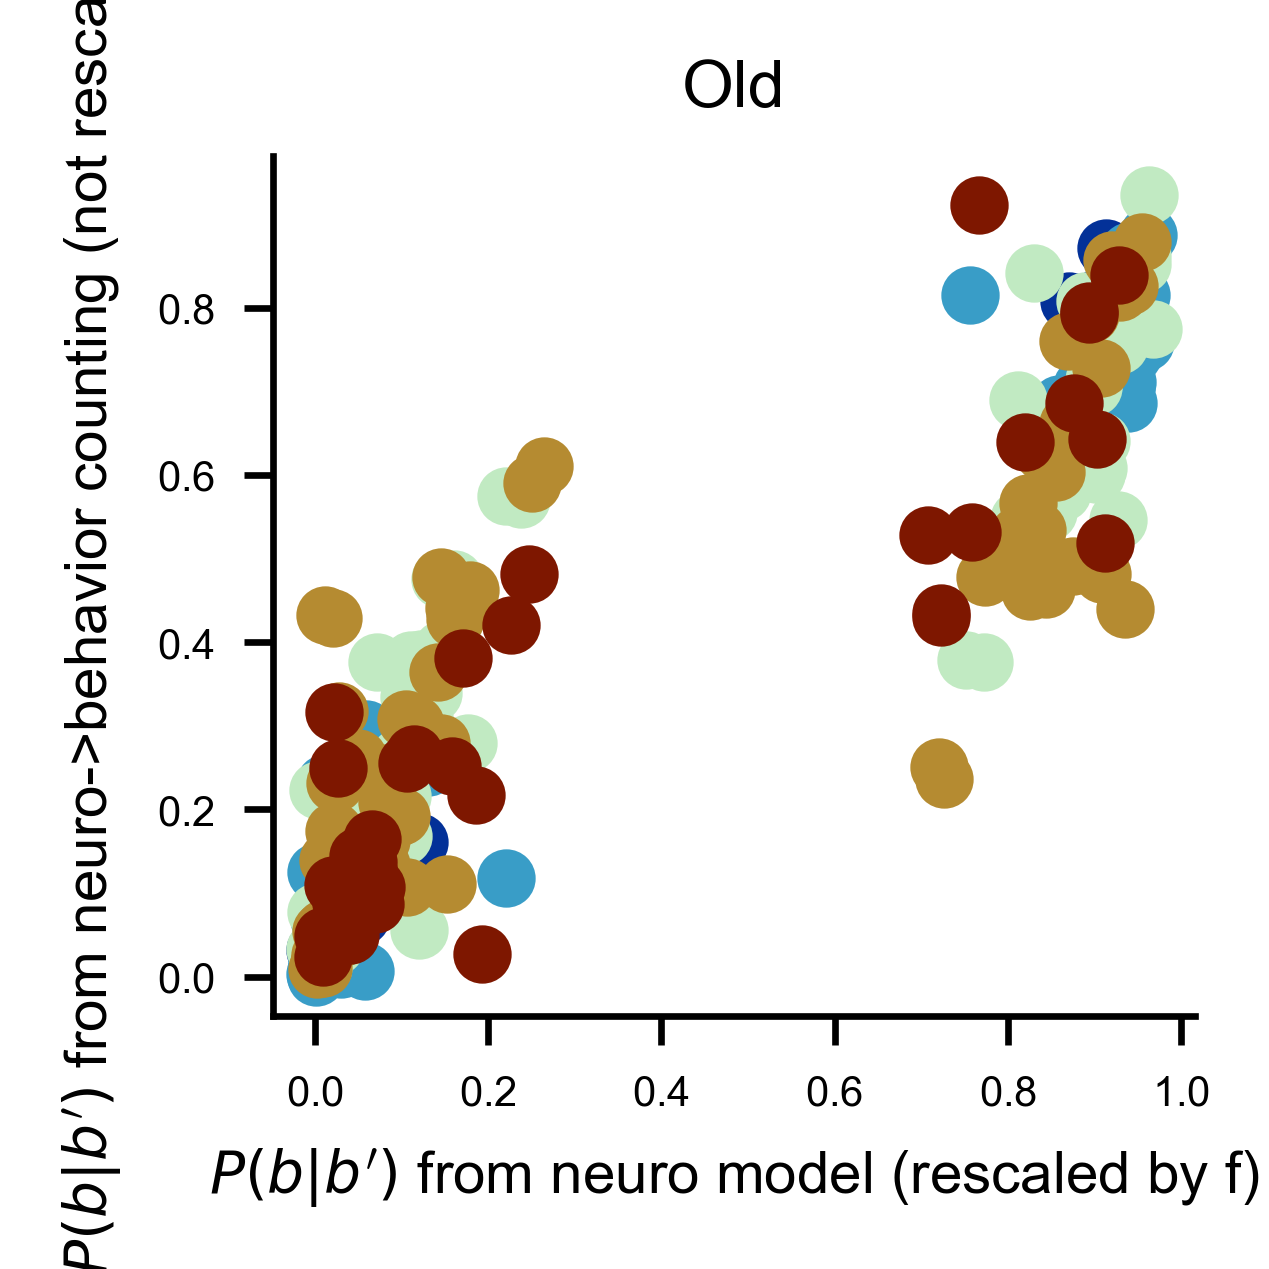

In [31]:
nGENPATH = Path("/home/mkk/Downloads/behavior_from_ARTR5/")
fig, ax = plt.subplots()
ax.set_title("Old")
for artr in ALL_ARTRs:
    _, temp = artr
    mT = load_ARTR_transmat(nMODELPATH, *artr)
    dt = load_ARTR_dt(nMODELPATH, *artr)
    mT = np.linalg.matrix_power(mT, round(1/(0.44)))
    
    nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
    nT = MC.bout_transitions(nstate)
    
    ax.scatter(mT.ravel(), nT.ravel(), color=TEMPS_COLS[temp])

ax.set_xlabel("$P(b|b')$ from neuro model (rescaled by f)")
ax.set_ylabel("$P(b|b')$ from neuro->behavior counting (not rescaled)")

In [312]:
L1, bL1, nL1 = [], [], []
diagi, diagj = np.diag_indices(3)

for temp in TEMPS[:2]:
    BT = load_transmat(bMODELPATH, "g3", temp)
    
    bangle, bdt, bdist, bstate = load_genbehavior(bGENPATH, temp)
    bT = MC.bout_transitions([bstate])
    
    nT = []
    for artr in ALL_ARTRs[ALL_ARTRs[:,1] == temp]:
        nangle, ndt, ndist, nstate = load_genneuro(nGENPATH, *artr)
        nT.append(np.linalg.matrix_power(MC.bout_transitions(nstate), 4))
    nT = np.array(nT)

    L1.append(-1/np.log(BT[diagi, diagj]))
    bL1.append(-1/np.log(bT[diagi, diagj]))
    nL1.append(-1/np.log(nT[:,diagi, diagj]))

In [307]:
L1 = np.array(L1)
bL1 = np.array(bL1)

In [308]:
nL1 = np.array([[L.mean(axis=0), L.std(axis=0)/np.sqrt(len(L))] for L in nL1])

In [309]:
nL1.shape

(5, 2, 3)

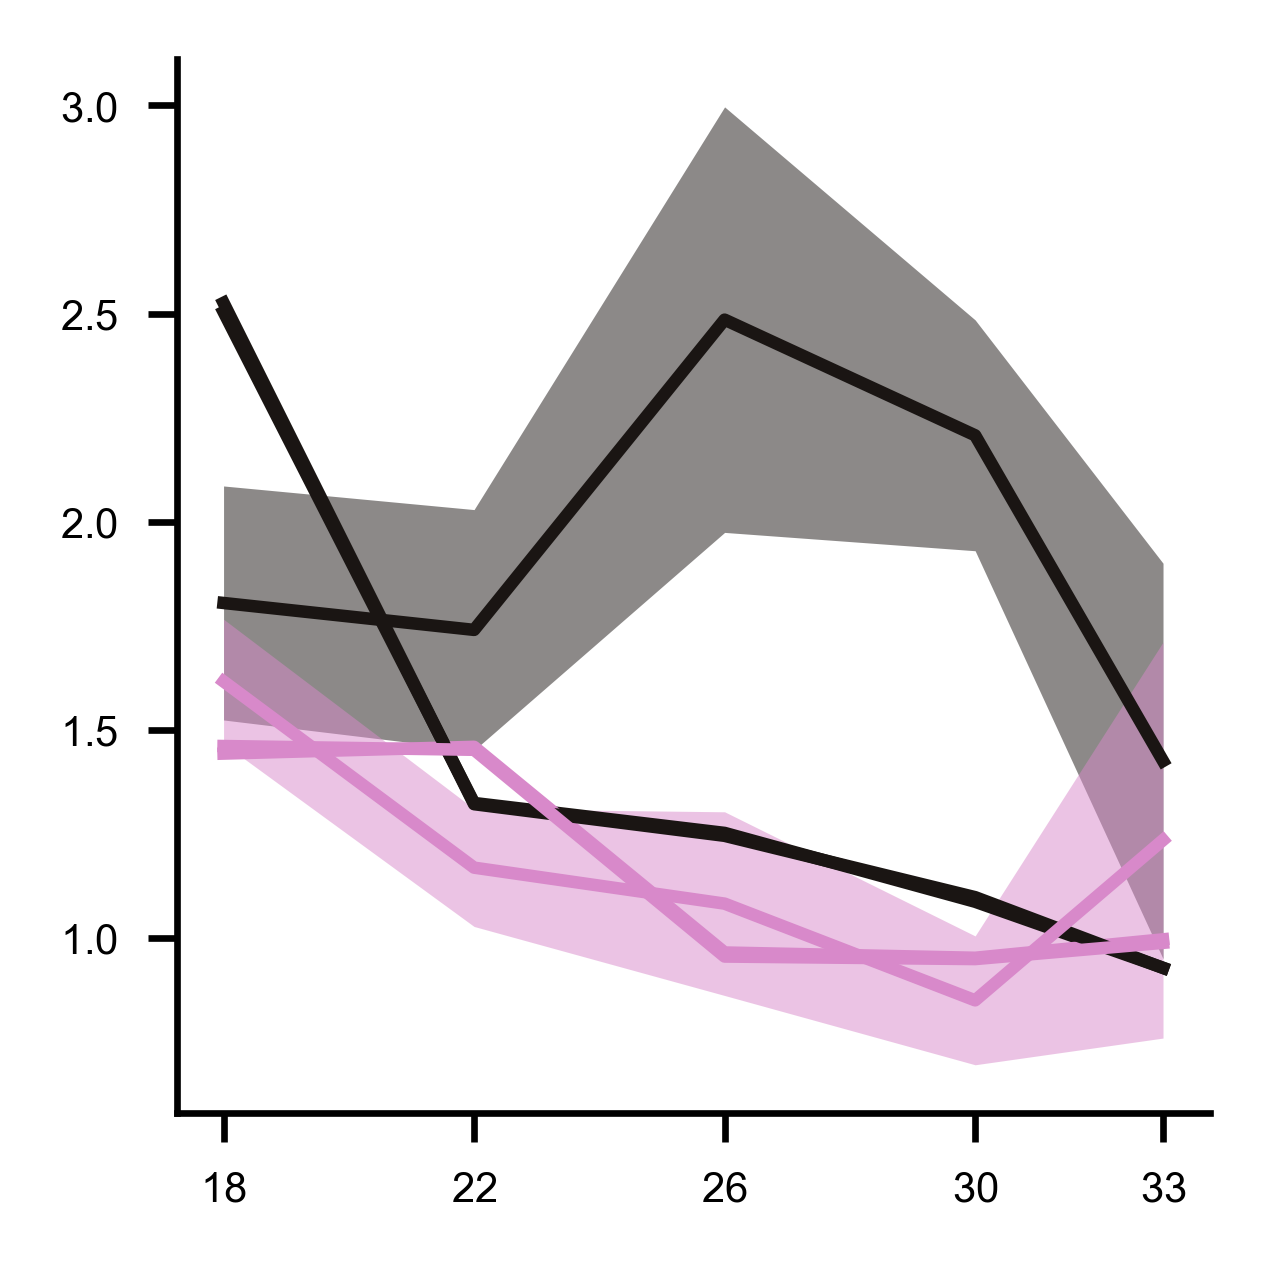

In [310]:
fig, ax = plt.subplots()
ax.plot(TEMPS, L1[:,0], color=FLR_colors[0])
ax.plot(TEMPS, L1[:,1], color=FLR_colors[2])

ax.plot(TEMPS, bL1[:,0], color=FLR_colors[0])
ax.plot(TEMPS, bL1[:,1], color=FLR_colors[2])

ax.fill_between(TEMPS, nL1[:,0,0]-nL1[:,1,0], nL1[:,0,0]+nL1[:,1,0], color=FLR_colors[0], alpha=0.5, linewidth=0)
ax.plot(TEMPS, nL1[:,0,0], color=FLR_colors[0])
ax.fill_between(TEMPS, nL1[:,0,1]-nL1[:,1,1], nL1[:,0,1]+nL1[:,1,1], color=FLR_colors[2], alpha=0.5, linewidth=0)
ax.plot(TEMPS, nL1[:,0,1], color=FLR_colors[2])

ax.set_xticks(TEMPS)